<a href="https://colab.research.google.com/github/vs5938/mlcybersecurity-1/blob/main/fingerprinting_using_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import sys
import numpy as np
from sklearn.feature_selection import SelectFromModel

In [ ]:
def neighborhood(iterable):
    iterator = iter(iterable)
    prev = (0)
    item = next(iterator)  # throws StopIteration if empty.
    for nxt in iterator:
        yield (prev,item,nxt)
        prev = item
        item = nxt
    yield (prev,item,None)

In [ ]:
def chunkIt(seq, num):
  avg = len(seq) / float(num)
  out = []
  last = 0.0
  while last < len(seq):
    out.append(seq[int(last):int(last + avg)])
    last += avg
  return out

In [ ]:
"""Non-feeder functions"""
import pdb;

def get_pkt_list(trace_data):
    first_line = trace_data[0]
    first_line = first_line.split('\t')
    #pdb.set_trace()
    first_time = float(first_line[0])
    dta = []
    for line in trace_data:
        a = line
        b = a.split('\t')

        if float(b[1]) > 0:
            #dta.append(((float(b[0])- first_time), abs(int(b[2])), 1))
            dta.append(((float(b[0])- first_time), 1))
        else:
            #dta.append(((float(b[1]) - first_time), abs(int(b[2])), -1))
            dta.append(((float(b[0]) - first_time), -1))
    return dta


In [ ]:
def In_Out(list_data):
    In = []
    Out = []
    for p in list_data:
        if p[1] == -1:
            In.append(p)
        if p[1] == 1:
            Out.append(p)
    return In, Out

In [ ]:
def inter_pkt_time(list_data):
    times = [x[0] for x in list_data]
    temp = []
    for elem,next_elem in zip(times, times[1:]+[times[0]]):
        temp.append(next_elem-elem)
    return temp[:-1]

In [ ]:
def interarrival_times(list_data):
    In, Out = In_Out(list_data)
    IN = inter_pkt_time(In)
    OUT = inter_pkt_time(Out)
    TOTAL = inter_pkt_time(list_data)
    return IN, OUT, TOTAL

In [ ]:

def interarrival_maxminmeansd_stats(list_data):
    interstats = []
    In, Out, Total = interarrival_times(list_data)
    if In and Out:
        avg_in = sum(In)/float(len(In))
        avg_out = sum(Out)/float(len(Out))
        avg_total = sum(Total)/float(len(Total))
        interstats.append((max(In), max(Out), max(Total), avg_in, avg_out, avg_total, np.std(In), np.std(Out), np.std(Total), np.percentile(In, 75), np.percentile(Out, 75), np.percentile(Total, 75)))
    elif Out and not In:
        avg_out = sum(Out)/float(len(Out))
        avg_total = sum(Total)/float(len(Total))
        interstats.append((0, max(Out), max(Total), 0, avg_out, avg_total, 0, np.std(Out), np.std(Total), 0, np.percentile(Out, 75), np.percentile(Total, 75)))
    elif In and not Out:
        avg_in = sum(In)/float(len(In))
        avg_total = sum(Total)/float(len(Total))
        interstats.append((max(In), 0, max(Total), avg_in, 0, avg_total, np.std(In), 0, np.std(Total), np.percentile(In, 75), 0, np.percentile(Total, 75)))
    else:
        interstats.extend(([0]*15))
    return interstats


In [ ]:
def time_percentile_stats(trace_data):
    Total = get_pkt_list(trace_data)
    In, Out = In_Out(Total)
    In1 = [x[0] for x in In]
    Out1 = [x[0] for x in Out]
    Total1 = [x[0] for x in Total]
    STATS = []
    if In1:
        STATS.append(np.percentile(In1, 25)) # return 25th percentile
        STATS.append(np.percentile(In1, 50))
        STATS.append(np.percentile(In1, 75))
        STATS.append(np.percentile(In1, 100))
    if not In1:
        STATS.extend(([0]*4))
    if Out1:
        STATS.append(np.percentile(Out1, 25)) # return 25th percentile
        STATS.append(np.percentile(Out1, 50))
        STATS.append(np.percentile(Out1, 75))
        STATS.append(np.percentile(Out1, 100))
    if not Out1:
        STATS.extend(([0]*4))
    if Total1:
        STATS.append(np.percentile(Total1, 25)) # return 25th percentile
        STATS.append(np.percentile(Total1, 50))
        STATS.append(np.percentile(Total1, 75))
        STATS.append(np.percentile(Total1, 100))
    if not Total1:
        STATS.extend(([0]*4))
    return STATS

In [ ]:
def number_pkt_stats(trace_data):
    Total = get_pkt_list(trace_data)
    In, Out = In_Out(Total)
    return len(In), len(Out), len(Total)

In [ ]:
def first_and_last_30_pkts_stats(trace_data):
    Total = get_pkt_list(trace_data)
    first30 = Total[:30]
    last30 = Total[-30:]
    first30in = []
    first30out = []
    for p in first30:
        if p[1] == -1:
            first30in.append(p)
        if p[1] == 1:
            first30out.append(p)
    last30in = []
    last30out = []
    for p in last30:
        if p[1] == -1:
            last30in.append(p)
        if p[1] == 1:
            last30out.append(p)
    stats= []
    stats.append(len(first30in))
    stats.append(len(first30out))
    stats.append(len(last30in))
    stats.append(len(last30out))
    return stats


In [ ]:
def pkt_concentration_stats(trace_data):
    Total = get_pkt_list(trace_data)
    #pdb.set_trace()
    chunks= [Total[x:x+20] for x in xrange(0, len(Total), 20)]
    concentrations = []
    for item in chunks:
        c = 0
        for p in item:
            if p[1] == 1:
                c+=1
        concentrations.append(c)
    return np.std(concentrations), sum(concentrations)/float(len(concentrations)), np.percentile(concentrations, 50), min(concentrations), max(concentrations), concentrations


In [ ]:
#Average number packets sent and received per second
def number_per_sec(trace_data):
    Total = get_pkt_list(trace_data)
    last_time = Total[-1][0]
    last_second = math.ceil(last_time)
    temp = []
    l = []
    for i in range(1, int(last_second)+1):
        c = 0
        for p in Total:
            if p[0] <= i:
                c+=1
        temp.append(c)
    #pdb.set_trace()
    for prev,item,next in neighborhood(temp):
        x = item - prev
        l.append(x)
    avg_number_per_sec = sum(l)/float(len(l))
    return avg_number_per_sec, np.std(l), np.percentile(l, 50), min(l), max(l), l

In [ ]:
def avg_pkt_ordering_stats(trace_data):
    Total = get_pkt_list(trace_data)
    c1 = 0
    c2 = 0
    temp1 = []
    temp2 = []
    for p in Total:
        if p[1] == 1:
            temp1.append(c1)
        c1+=1
        if p[1] == -1:
            temp2.append(c2)
        c2+=1
    avg_in = sum(temp1)/float(len(temp1))
    avg_out = sum(temp2)/float(len(temp2))

    return avg_in, avg_out, np.std(temp1), np.std(temp2)


In [ ]:
def perc_inc_out(trace_data):
    Total = get_pkt_list(trace_data)
    In, Out = In_Out(Total)
    percentage_in = len(In)/float(len(Total))
    percentage_out = len(Out)/float(len(Total))
    return percentage_in, percentage_out

In [ ]:
col = ['In packet Time','Out packet Time','Total packet time','avg in packet time','avg out packet time','avg total time','In std deviation time','Out std deviation time','total std deviation time','In 75% quantile time','Out 75% quantile time','Total 75% quantile time','In 25% quantile','In 50% quantile','In 75% quantile','In 100% quantile','Out 25% quantile','Out 50% quantile','Out 75% quantile','Out 100% quantile','Total 25% quantile','Total 50% quantile','Total 75% quantile','Total 100% quantile','In length','Out length','Total length','first 30 in', 'first 30 out', 'last 30 in','last 30 out','packet concentration','packet concentration avg','avg no. of packets sent per sec','std_dev_pckts_sent_per_sec','avg in packet ordering','avg out packet ordering','in std dev of packet ordering','out std dev of packet ordering','packet concentration median', 'median_no_of_pckts_sentper_sec','min_no_of_packets_sent_per_sec','max_no_of_pckts_sent_per_sec','max concentration','in percentage of packets', 'out percentage of packets']
len(col)
col1 = ['alt conc sum','alt conc per sec sum','intertime stats sum','time stats sum','no. of packets sum','packets sent per sec','concentrations']

In [ ]:

'min concentration', 







def TOTAL_FEATURES(trace_data, max_size=175):
    list_data = get_pkt_list(trace_data)
    ALL_FEATURES = []


    # ------TIME--------
    intertimestats = [x for x in interarrival_maxminmeansd_stats(list_data)[0]] #12
    timestats = time_percentile_stats(trace_data) #12
    number_pkts = list(number_pkt_stats(trace_data)) #3
    thirtypkts = first_and_last_30_pkts_stats(trace_data) #4
    stdconc, avgconc, medconc, minconc, maxconc, conc = pkt_concentration_stats(trace_data) #6
    avg_per_sec, std_per_sec, med_per_sec, min_per_sec, max_per_sec, per_sec = number_per_sec(trace_data) #
    avg_order_in, avg_order_out, std_order_in, std_order_out = avg_pkt_ordering_stats(trace_data) #
    perc_in, perc_out = perc_inc_out(trace_data)

    altconc = []
    alt_per_sec = []
    altconc = [sum(x) for x in chunkIt(conc, 70)]
    alt_per_sec = [sum(x) for x in chunkIt(per_sec, 20)]
    if len(altconc) == 70:
        altconc.append(0)
    if len(alt_per_sec) == 20:
        alt_per_sec.append(0)
    # TIME Features
    ALL_FEATURES.extend(intertimestats) #12
    ALL_FEATURES.extend(timestats) #12
    ALL_FEATURES.extend(number_pkts) #3
    ALL_FEATURES.extend(thirtypkts) #4
    ALL_FEATURES.append(stdconc) #1
    ALL_FEATURES.append(avgconc) #1
    ALL_FEATURES.append(avg_per_sec) #1
    ALL_FEATURES.append(std_per_sec) #1
    ALL_FEATURES.append(avg_order_in) #1
    ALL_FEATURES.append(avg_order_out) #1
    ALL_FEATURES.append(std_order_in) #1
    ALL_FEATURES.append(std_order_out)#1
    ALL_FEATURES.append(medconc)#1
    ALL_FEATURES.append(med_per_sec)#1
    ALL_FEATURES.append(min_per_sec)#1
    ALL_FEATURES.append(max_per_sec)#1
    ALL_FEATURES.append(maxconc)#1
    ALL_FEATURES.append(perc_in)#1
    ALL_FEATURES.append(perc_out)#1
    ALL_FEATURES.extend(altconc) #70
    ALL_FEATURES.extend(alt_per_sec) #20
    ALL_FEATURES.append(sum(altconc)) #1
    ALL_FEATURES.append(sum(alt_per_sec)) #1
    ALL_FEATURES.append(sum(intertimestats)) #1
    ALL_FEATURES.append(sum(timestats)) #1
    ALL_FEATURES.append(sum(number_pkts)) #1

    # This is optional, since all other features are of equal size this gives the first n features
    # of this particular feature subset, some may be padded with 0's if too short.

    ALL_FEATURES.extend(conc) #20

    ALL_FEATURES.extend(per_sec) #remaining
    #print(len(ALL_FEATURES))

    while len(ALL_FEATURES)<max_size:
        ALL_FEATURES.append(0)
    features = ALL_FEATURES[:max_size]

    return tuple(features)

In [ ]:
import csv
import sys
from sys import stdout
#import RF_fextract
import numpy as np
#import matplotlib.pylab as plt
import operator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import tree
import sklearn.metrics as skm
import scipy
#import dill
import random
import os
from collections import defaultdict
import argparse
from itertools import chain
from past.builtins import xrange

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
############ Feeder functions ############

def chunks(l, n):
    """ Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

def checkequal(lst):
    return lst[1:] == lst[:-1]

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloaded = drive.CreateFile({'id': '1SSwOHbTTPQJcpjyMtl9s2vdFGNonCKV7'})
# downloaded.GetContentFile('full.zip')

downloaded = drive.CreateFile({'id': '16qWgC0NWnvDs3PwHMA63Ou2F2DKormVH'})
downloaded.GetContentFile('wang-knn.zip')

In [200]:
!unzip -o wang-knn.zip

In [ ]:
#data_path="undefended/"  # trace data path
data_path=""  # trace data path
num_sites=95               # number of sites (max 95)
num_instances=100          # number of instances per site (max 100)
file_ext=""                # trace file extension
max_length =2000           # maximum number of packet directions to use

In [ ]:
from pathlib import Path
def get_data():
    """

    :return: a numpy ndarray of dimension (m x (n+1)) containing direction data
        loaded from the files, where `m` is the number of data samples and `n`
        is length of direction packets (restricted to 500 to consume less
        computation time and memory). The last column in the data contains the
        class labels of the `m` samples, which are the website numbers.

    This function loads the data from the files and creates a numpy data matrix
    with each row as a data sample and the columns containing packet direction.
    The last column of the data is the label, which is the website to which the
    instance belongs.
    """

    # read data from files
    print("loading data...")
    data = []
    data_new = []
    for site in range(0, num_sites):
        print('site is', site)
        for instance in range(0, num_instances):
            #print('site is', site, 'instance is', instance)
            file_name = str(site) + "-" + str(instance)
            my_file = Path(data_path + file_name + file_ext)
            if my_file.exists():
            # Directory of the raw data
                with open(data_path + file_name + file_ext, "r") as file_pt:
                    directions = []
                    tcp_dump = file_pt.readlines();
                    #pdb.set_trace()
                    g = []
                    g.append(TOTAL_FEATURES(tcp_dump))
                    # for line in file_pt:
                    #     x = line.strip().split('\t')
                    #     directions.append(1 if float(x[1]) > 0 else -1)
                    # if len(directions) < max_length:
                    #     #ipdb.set_trace()
                    #     zend = max_length - len(directions)
                    #     directions.extend([0] * zend)
                    # elif len(directions) > max_length:
                    #     directions = directions[:max_length]
                    # data.append(directions + [site])
                    #pdb.set_trace()
                    # if type(data_new) is NoneType:
                    #   pdb.set_trace()
                    data_new.append(list(g[0]) + [site])

    print("done")
    return np.array(data),data_new

In [ ]:
data = get_data()

loading data...
site is 0
site is 1
site is 2
site is 3
site is 4
site is 5
site is 6
site is 7
site is 8
site is 9
site is 10
site is 11
site is 12
site is 13
site is 14
site is 15
site is 16
site is 17
site is 18
site is 19
site is 20
site is 21
site is 22
site is 23
site is 24
site is 25
site is 26
site is 27
site is 28
site is 29
site is 30
site is 31
site is 32
site is 33
site is 34
site is 35
site is 36
site is 37
site is 38
site is 39
site is 40
site is 41
site is 42
site is 43
site is 44
site is 45
site is 46
site is 47
site is 48
site is 49
site is 50
site is 51
site is 52
site is 53
site is 54
site is 55
site is 56
site is 57
site is 58
site is 59
site is 60
site is 61
site is 62
site is 63
site is 64
site is 65
site is 66
site is 67
site is 68
site is 69
site is 70
site is 71
site is 72
site is 73
site is 74
site is 75
site is 76
site is 77
site is 78
site is 79
site is 80
site is 81
site is 82
site is 83
site is 84
site is 85
site is 86
site is 87
site is 88
site is 89
site

In [ ]:
len(data[1][0])

176

In [ ]:
import pandas as pd
df = pd.DataFrame(data[1])

In [ ]:
df_X = df[df.columns[:175]]
df_Y = df[df.columns[175]]

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

In [ ]:
col_list = []
col_list.extend(col)
x = ['chunk_alt_conc_' + str(x) for x in range(1,71)]
col_list.extend(x)
x = ['chunk_alt_per_sec_' + str(x) for x in range(1, 21)]
col_list.extend(x)
col_list.extend(col1)
x = ['chunk_conc_' + str(x) for x in range(1,21)]
col_list.extend(x)
x = ['chunk_per_sec_' + str(x) for x in range(0,175 -len(col_list))]
col_list.extend(x)
#df_X.columns = col_list
col_list

['In packet Time',
 'Out packet Time',
 'Total packet time',
 'avg in packet time',
 'avg out packet time',
 'avg total time',
 'In std deviation time',
 'Out std deviation time',
 'total std deviation time',
 'In 75% quantile time',
 'Out 75% quantile time',
 'Total 75% quantile time',
 'In 25% quantile',
 'In 50% quantile',
 'In 75% quantile',
 'In 100% quantile',
 'Out 25% quantile',
 'Out 50% quantile',
 'Out 75% quantile',
 'Out 100% quantile',
 'Total 25% quantile',
 'Total 50% quantile',
 'Total 75% quantile',
 'Total 100% quantile',
 'In length',
 'Out length',
 'Total length',
 'first 30 in',
 'first 30 out',
 'last 30 in',
 'last 30 out',
 'packet concentration',
 'packet concentration avg',
 'avg no. of packets sent per sec',
 'std_dev_pckts_sent_per_sec',
 'avg in packet ordering',
 'avg out packet ordering',
 'in std dev of packet ordering',
 'out std dev of packet ordering',
 'packet concentration median',
 'median_no_of_pckts_sentper_sec',
 'min_no_of_packets_sent_per_se

In [ ]:
df_X.columns = col_list

In [ ]:
df_X

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
0,0.667817,2.408265,2.087620,0.029254,0.252148,0.029828,0.079796,0.356885,0.104496,0.000247,...,1,1,8,0,0,6,0,0,6,2
1,1.132841,2.731211,2.346404,0.052963,0.342813,0.052886,0.152386,0.451278,0.168686,0.000452,...,4,17,13,7,11,50,10,4,66,21
2,3.757673,3.445978,3.145042,0.046259,0.249897,0.039851,0.229974,0.470561,0.178093,0.004480,...,23,9,60,13,81,90,33,15,0,0
3,4.528484,4.523505,4.303049,0.039977,0.216771,0.034226,0.269757,0.600969,0.233256,0.001148,...,54,92,65,14,0,0,0,2,1,0
4,0.560542,0.672489,0.507635,0.031243,0.171636,0.027595,0.086325,0.181397,0.069297,0.002039,...,51,12,79,61,63,16,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,1.264946,0.935053,0.834574,0.006848,0.041775,0.006251,0.048796,0.103598,0.040443,0.000000,...,0,2,0,0,0,8,8,0,0,0
8546,1.318270,1.508081,1.048364,0.017629,0.171720,0.016678,0.063964,0.289742,0.061331,0.000000,...,1,0,1,0,1,1,0,1,7,6
8547,4.167371,5.950986,4.167371,0.015896,0.143694,0.014484,0.143257,0.559810,0.128849,0.000000,...,0,2,1,0,0,0,0,4,0,0
8548,1.105477,1.897691,0.751067,0.016852,0.158187,0.015294,0.060287,0.265256,0.047951,0.000000,...,1,13,1,0,0,1,1,1,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_X, df_Y, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
metrics.accuracy_score(y_valid, y_pred)

0.92046783625731

In [ ]:
importance = model.feature_importances_

In [ ]:
importance

array([0.00435677, 0.00480571, 0.0042699 , 0.00652777, 0.0063151 ,
       0.00644085, 0.00448077, 0.00419323, 0.00458795, 0.00471887,
       0.00734545, 0.00474354, 0.00785734, 0.00615416, 0.00528066,
       0.00548821, 0.0071195 , 0.00725469, 0.0060613 , 0.00530598,
       0.00671999, 0.00644238, 0.00561069, 0.00623635, 0.03219061,
       0.03072036, 0.02971658, 0.01495636, 0.01346287, 0.00562651,
       0.00589701, 0.01877401, 0.02664636, 0.00684387, 0.00700236,
       0.02679908, 0.0298316 , 0.03058359, 0.0288308 , 0.00481853,
       0.00601512, 0.00164215, 0.00690575, 0.00755464, 0.03150345,
       0.0302122 , 0.01028044, 0.01243044, 0.00882079, 0.00756385,
       0.00565171, 0.00516636, 0.00390992, 0.00517624, 0.00220574,
       0.0020387 , 0.00130159, 0.00342051, 0.00142015, 0.00205137,
       0.00171935, 0.00276581, 0.00292445, 0.0020201 , 0.00083619,
       0.00178169, 0.00077038, 0.00071746, 0.00072722, 0.00196148,
       0.00079182, 0.00103326, 0.00092672, 0.00128044, 0.00095

In [ ]:
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.xlabel("Feature No")
# pyplot.ylabel("Feature Importance")
# pyplot.show()

In [ ]:
selectFromModel = SelectFromModel(model)
selectFromModel.get_support()

array([False, False, False,  True,  True,  True, False, False, False,
       False,  True, False,  True,  True, False, False,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
selected_feat= df_X.columns[(selectFromModel.get_support())]
len(selected_feat)

48

In [ ]:
indices = np.argsort(importance)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
sorted_feats = sorted(feats.items(),key=lambda x:x[1],reverse=True)
sorted_feats_dict = dict(sorted_feats)

<Axes: >

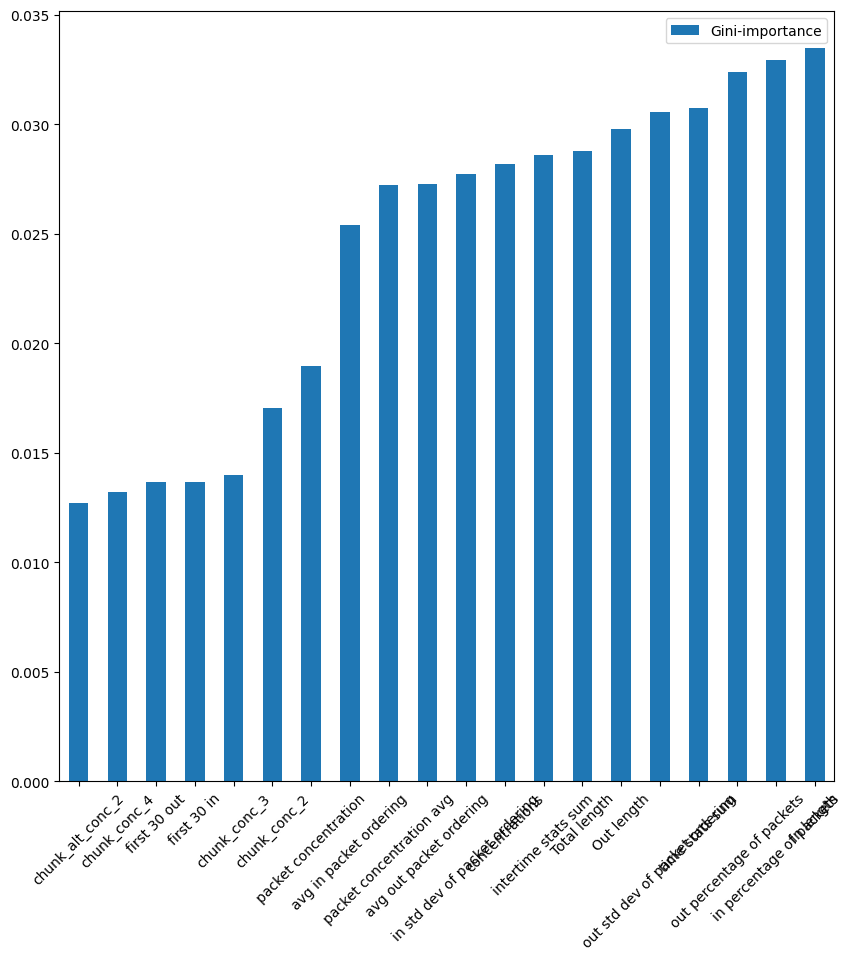

In [ ]:
importances = pd.DataFrame.from_dict(sorted_feats_dict, orient='index').rename(columns={0: 'Gini-importance'})
pyplot.rcParams['figure.figsize'] = [10, 10]
importances[0:20].sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [ ]:
sorted_feats[0:25]

[('time stats sum', 0.03184727145960179),
 ('out percentage of packets', 0.03099690455671789),
 ('In length', 0.0309728735124474),
 ('packet concentration avg', 0.030402958741964525),
 ('Total length', 0.03015269278525476),
 ('Out length', 0.03010755073932327),
 ('avg out packet ordering', 0.0299433879469035),
 ('out std dev of packet ordering', 0.029369594612199523),
 ('in percentage of packets', 0.02914621372037522),
 ('concentrations', 0.028866250926424145),
 ('intertime stats sum', 0.02861754623532257),
 ('in std dev of packet ordering', 0.028485225411174216),
 ('avg in packet ordering', 0.02660436786396131),
 ('packet concentration', 0.017835530317759828),
 ('chunk_conc_2', 0.016563497591748643),
 ('chunk_conc_3', 0.015505286692103104),
 ('chunk_alt_conc_2', 0.01401110826993855),
 ('first 30 in', 0.013977542459710605),
 ('chunk_conc_4', 0.01340970175499485),
 ('first 30 out', 0.013063924576265444),
 ('chunk_conc_7', 0.011461004583760096),
 ('chunk_conc_6', 0.009476652298918553),
 

In [ ]:
  accuracy_with_number_of_features = [[0,0]]
  # features = [t[0] for t in sorted_feats[0:5]]
  # model = RandomForestClassifier()
  # model.fit(X_train[features], y_train)
  # y_pred = model.predict(X_valid[features])
  # accuracy_with_number_of_features.append([5,metrics.accuracy_score(y_valid, y_pred)])
  # accuracy_with_number_of_features
  for i in range(5,61,5):
      features = [t[0] for t in sorted_feats[0:i]]
      model = RandomForestClassifier()
      model.fit(X_train[features], y_train)
      print(i)
      y_pred = model.predict(X_valid[features])
      accuracy_with_number_of_features.append([i,metrics.accuracy_score(y_valid, y_pred)])

5
10
15
20
25
30
35
40
45
50
55
60


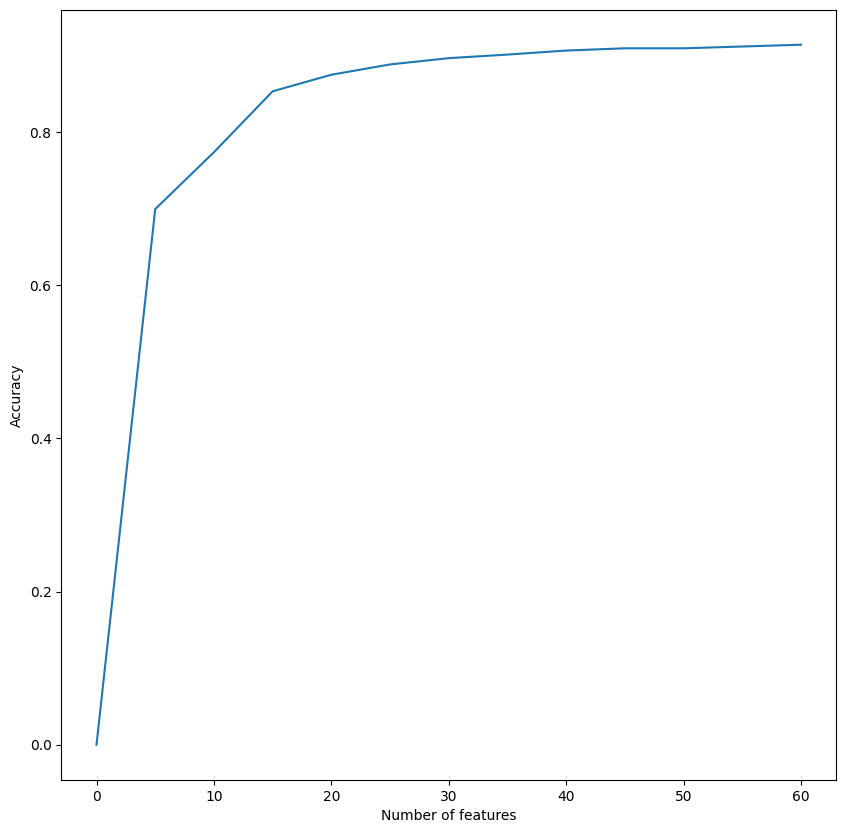

In [ ]:
pyplot.plot([x[0] for x in accuracy_with_number_of_features], [x[1] for x in accuracy_with_number_of_features])
pyplot.xlabel("Number of features")
pyplot.ylabel("Accuracy")
pyplot.show()

In [ ]:
sorted_feats_importance_experiments = []
for i in range(5):
  features = [t[0] for t in sorted_feats[0:20]]
  model = RandomForestClassifier(random_state=i)
  model.fit(X_train[features], y_train)
  importance = model.feature_importances_
  feats = {} # a dict to hold feature_name: feature_importance
  for feature, importance in zip(features, model.feature_importances_):
      feats[feature] = importance #add the name/value pair 
  sorted_feats_i = sorted(feats.items(),key=lambda x:x[1],reverse=True)
  #sorted_feats_dict_i = dict(sorted_feats_i[0:20])
  sorted_feats_importance_experiments.append(sorted_feats_i)


In [ ]:
sorted_feats_importance_experiments

[[('In length', 0.06651766642415576),
  ('out percentage of packets', 0.06392163668852074),
  ('in percentage of packets', 0.061672575495395475),
  ('in std dev of packet ordering', 0.05998294604166715),
  ('avg in packet ordering', 0.0598715444349648),
  ('packet concentration avg', 0.05673251470103633),
  ('Out length', 0.05487374891737681),
  ('intertime stats sum', 0.05356422405676545),
  ('out std dev of packet ordering', 0.05306866933373962),
  ('avg out packet ordering', 0.050741231037661746),
  ('concentrations', 0.05013559165816636),
  ('packet concentration', 0.04774732385975236),
  ('time stats sum', 0.04703825696976019),
  ('Total length', 0.04644308054138393),
  ('chunk_conc_2', 0.04512696274607102),
  ('chunk_conc_3', 0.04205861033456986),
  ('first 30 out', 0.03744271651572854),
  ('first 30 in', 0.03669935545624878),
  ('chunk_conc_4', 0.03556976791670385),
  ('chunk_alt_conc_2', 0.030791576870331225)],
 [('In length', 0.06567872094155368),
  ('in percentage of packets'

In [ ]:
sorted_feats_dict_i = dict(sorted_feats_importance_experiments[0])
keys = list(sorted_feats_dict_i.keys())
#print(keys[0])
importance_vals = []

for i in range(20):
  importance_val = []
  for j in range(5):
    importance_key = dict(sorted_feats_importance_experiments[j])
    importance_val.append(importance_key[keys[i]])
  importance_vals.append(importance_val)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8884a2d0a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8884a4bc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8884a2da30>,
 'medians': [<matplotlib.lines.Line2D at 0x7f8884a4b5e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8884a63880>,
 'means': []}

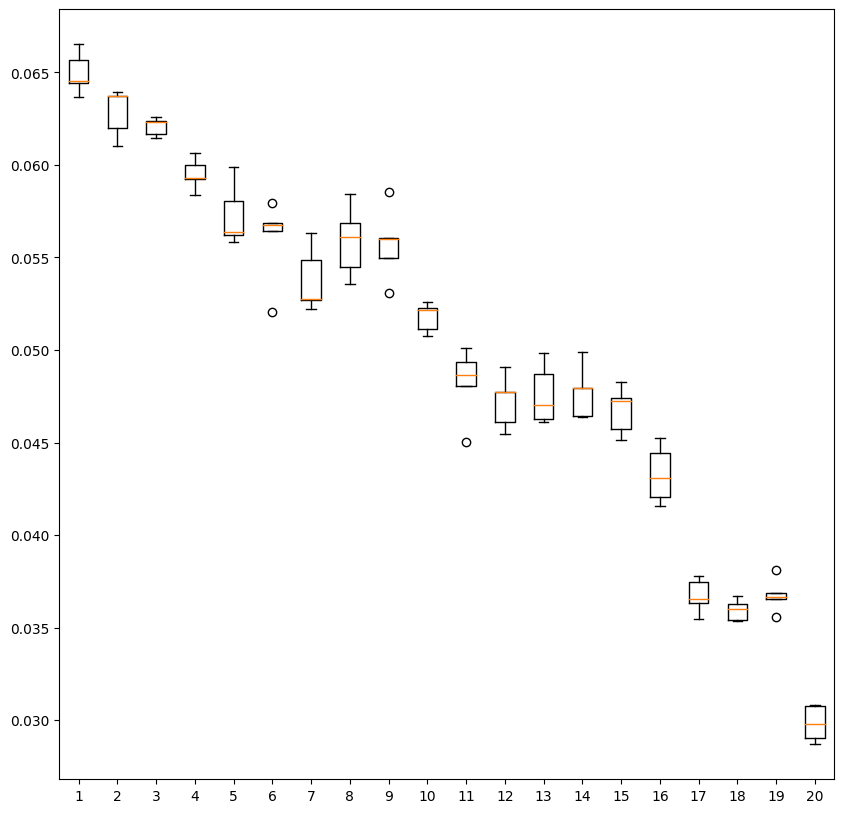

In [ ]:
#transpose_list = np.array(sorted_feats_importance_experiments).T.tolist()
# sorted_feats_importance_experiments
# importance_vals
pyplot.boxplot(importance_vals)

In [ ]:
sorted_idx = importance.argsort()
sorted_idx_subset = sorted_idx[0:5]
sorted_idx_subset

array([0])

In [ ]:
y_pred_actual = model.predict(X_valid)

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_valid, y_pred_actual)
#0.9198830409356725

0.9198830409356725

In [ ]:
y_pred

In [ ]:
probabilites = model.predict_proba(X_valid)

In [ ]:
prob_x = []
for i in range(len(probabilites)):
    prob_x.append(np.argmax(probabilites[i]))

In [ ]:
for i in range(len(prob_x)):
  if prob_x[i]!=y_pred[i]:
      print(str(i))

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_pred,probabilites)

In [ ]:

entropy_loss_per_sample =[]
m = []
for i in range(len(y_pred)):
  #for j in range(len(prob_x)):
    # k = np.argmax(probabilites[j])
    # m.append(k)
    #if j == y_pred[i] :
      # if probabilites[j][y_pred[i]] ==0: 
      #   print('probobaility is zero')
      entropy_loss_per_sample.append(-1*np.log(probabilites[i][y_pred[i]]))

In [ ]:
sum(entropy_loss_per_sample)/len(y_pred)

In [ ]:
# class RandomForest:
#   def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_features=None):
#     self.n_trees = n_trees
#     self.max_depth = max_depth
#     self.min_samples_split = min_samples_split
#     self.n_features = n_features
#     self.trees = []
  
#   def fit(self,):
#     self.trees = []

#     for _ in range(self.n_trees):
#       tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_sample_split,n_features=self.n_features)

#       X_sample, y_sample = self._bootstrap_samples(X,y)
#       tree.fit(X_sample, y_sample)

#   def _bootstrap_samples(self, X,y):
#     n_samples = X.shape[0]
#     idxs = np.random.choice(n_samples,n_samples, replace=True)
#     return X[idxs],y[idxs]
  
  

#   def _most_common_label(self, y):
#           counter = Counter(y)
#           value = counter.most_common(1)[0][0]
#           return value;

#   def predict(self, X):
#     predictions = np.array([tree.predict(X) for tree in self.trees])
#     tree_preds = np.swapaxes(predictions,0,1)
#     np.array([self._most_common_label(pred) for pred in tree_preds])

# def predict_proba_smooth(x, model, temperature):
#     """
#     Computes the smoothed class probabilities for a given input image x using a random forest model.

#     Args:
#         x (numpy.ndarray): The input image, with shape (1, 175, 1).
#         model (sklearn.ensemble.RandomForestClassifier): The random forest model.
#         temperature (float): The temperature parameter used to smooth the class probabilities.

#     Returns:
#         numpy.ndarray: The smoothed class probabilities, with shape (1, n_classes).
#     """
#     # Get the class probabilities for the input image
#     probas = model.predict_proba(x.reshape(1, -1))[0]

#     # Smooth the class probabilities using temperature scaling
#     smoothed_probas = np.power(probas, 1 / temperature)
#     smoothed_probas /= np.sum(smoothed_probas)

#     return smoothed_probas.reshape((1, len(probas)))
def predict_proba_smooth(x, model, temperature):
    """
    Computes the smoothed class probabilities for a given input data x using a random forest model.

    Args:
        x (numpy.ndarray): The input data, with shape (1, n_features).
        model (sklearn.ensemble.RandomForestClassifier): The random forest model.
        temperature (float): The temperature parameter used to smooth the class probabilities.

    Returns:
        numpy.ndarray: The smoothed class probabilities, with shape (1, n_classes).
    """
    # Get the class probabilities for the input data
    probas = model.predict_proba(x)[0]

    # Smooth the class probabilities using temperature scaling
    smoothed_probas = np.power(probas, 1 / temperature)
    smoothed_probas /= np.sum(smoothed_probas)

    return smoothed_probas.reshape((1, len(probas)))

In [ ]:
import numpy as np

# def predict_smooth(x, trees, weights, num_classes, temperature):
#     scores = np.zeros(num_classes)
#     for i, tree in enumerate(trees):
#         node = tree.tree_
#         while True:
#             if np.all(node.children_left == -1) and np.all(node.children_right == -1): # leaf node
#                 scores[node.value.argmax()] += weights[i]
#                 break
#             else:
#                 j = node.feature[0]
#                 v = node.threshold[0]
#                 q = 1.0 / (1.0 + np.exp(-temperature * (x[0][j] - v)))
#                 if q >= 0.5:
#                     node = node.children_left
#                 else:
#                     node = node.children_right
#     return scores.argmax()

def predict_smooth(x, forest, weights, num_classes, temperature):
    scores = np.zeros(num_classes)
    for i, tree in enumerate(forest.estimators_):
          node = tree.tree_.value[0]
          while True:
              if isinstance(node, np.ndarray):  # Handle leaf node represented as ndarray
                  #class_counts = node[0]
                  #pdb.set_trace()
                  class_probs = ((tree.tree_.value)[0] / np.sum((tree.tree_.value)[0], axis=1, keepdims=True)).flatten()  # Normalize the counts to get probabilities
                  #pdb.set_trace()
                  scores += class_probs * weights[i]  # Add the weighted probabilities to the scores array
                  break
              elif np.all(node.children_left == -1) and np.all(node.children_right == -1): # Leaf node
                  scores[node.value.argmax()] += weights[i]
                  break
              else:
                  j = node.feature[0]
                  v = node.threshold[0]
                  q = 1.0 / (1.0 + np.exp(-temperature * (x[0,j] - v)))
                  if q >= 0.5:
                      node = node.children_left
                  else:
                      node = node.children_right
    return scores.argmax()

In [ ]:
#model.predict = lambda X: [predict_smooth(x, model.estimators_, model.estimator_weights_, model.n_classes_, 1.0) for x in X_valid]

In [ ]:
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf

def attack_smooth(f, x, y, epsilon, alpha, num_iter, temperature):
    x_adv = np.copy(x)
    for i in range(num_iter):
        grad = np.sign(compute_gradient_smooth(f, x_adv, y, temperature))
        x_adv = x_adv + alpha * grad
        x_adv = np.clip(x_adv, x - epsilon, x + epsilon)
        x_adv = np.clip(x_adv, 0, 1)  # ensure pixel values are in [0,1]
    return x_adv

# def compute_gradient_smooth(f, X, y, temperature):
#     X_tensor = np.expand_dims(X, axis=0)
#     X_tensor = X_tensor.reshape((1, 175, 1))
#     X_tensor_smooth = np.zeros_like(X_tensor)

#     for i in range(X_tensor.shape[2]):
#         X_tensor_smooth[:, i] = predict_proba_smooth(X_tensor[:, i], f, temperature)

#     y_tensor = np.zeros((1, f.n_classes_))
#     y_tensor[0, y] = 1

#     loss = keras.losses.categorical_crossentropy(y_tensor, X_tensor_smooth, from_logits=False, axis=1)
#     grad = tf.gradients(loss, X_tensor)

#     return grad.numpy()

def compute_gradient_smooth(f, X, y, temperature):
    """
    Computes the gradient of the smoothed cross-entropy loss with respect to the input data X.

    Args:
        f (sklearn.ensemble.RandomForestClassifier): The random forest model.
        X (numpy.ndarray): The input data, with shape (1, 175).
        y (int): The true label of the input data.
        temperature (float): The temperature parameter used to smooth the class probabilities.

    Returns:
        numpy.ndarray: The gradient of the smoothed loss with respect to X, with shape (1, 175).
    """
    # X_tensor = X.copy()
    # X_tensor_smooth_prob = np.zeros((1, 95))

    y_pred = []
    with tf.GradientTape() as tape:

        

        for i in range(X.shape[0]):
                # X_tensor = tf.convert_to_tensor(X[i], dtype=tf.float32)
                # X_tensor_smooth = tf.Variable(initial_value=X_tensor, dtype=tf.float32)
                #pdb.set_trace()
                X_tensor_smooth = tf.Variable(initial_value=X_valid.iloc[[i]], dtype=tf.float32)
                X_tensor_smoothed = predict_proba_smooth(X_tensor_smooth, f, temperature)
                #X_tensor_smooth1 = tf.Variable(initial_value=X_tensor_smoothed, dtype=tf.float32)
                y_pred.append(X_tensor_smoothed)
        
        y_pred = np.array(y_pred)
        y_tensor = tf.one_hot([y], depth=f.n_classes_, dtype=tf.float32)
        #pdb.set_trace()
        #y_pred = y_pred.numpy()
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = y_pred.numpy()
        #y_pred = np.reshape(y_pred, (y_pred[1], y_pred.shape[0], y_pred[2]))
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = np.squeeze(y_pred, axis=1)
        y_pred = np.expand_dims(y_pred, axis=0)
        y_pred = tf.convert_to_tensor(y_pred)
        #pdb.set_trace()
        y_tensor_np = y_tensor.numpy()  # Convert to numpy array
        #y_tensor_np_squeezed = np.squeeze(y_tensor_np, axis=1)  # Remove dimension with size 1
        y_tensor_squeezed = tf.convert_to_tensor(y_tensor_np) 
        #X_tf = tf.Variable(initial_value=X, dtype=tf.float32)
        loss = keras.losses.categorical_crossentropy(y_tensor_squeezed,y_pred)
        pdb.set_trace()
        grad = tape.gradient(loss, y_tensor_squeezed)
        #grad = np.gradient(y_tensor_squeezed,y_pred)
        # tf.debugging.check_numerics(grad, 'Gradient contains NaN or Inf values')
    return grad.numpy()



    # #for i in range(X_tensor.shape[1]):
    # X_tensor_smooth_prob = predict_proba_smooth(X_tensor, f, temperature)

    # y_tensor = np.zeros((1, f.n_classes_))
    # y_tensor[0, y] = 1

    # loss = keras.losses.categorical_crossentropy(y_tensor, X_tensor_smooth_prob, from_logits=False, axis=1)
    # grad = tf.gradients(loss, X_tensor)

    # return grad.numpy().reshape((1, -1))

# def compute_gradient_smooth(f, X, y, temperature):
#     X_tensor = np.expand_dims(X, axis=0)
#     X_tensor = X_tensor.reshape((1, 175, 1))
#     X_tensor_smooth = np.zeros_like(X_tensor)
#     #pdb.set_trace()
#     for i in range(X_tensor.shape[2]):
#         X_tensor_smooth[:, i] = predict_smooth(X_tensor[:, i], f, np.full(len(f.estimators_), 1/len(f.estimators_)).astype(int), f.n_classes_, temperature)
#     y_tensor = keras.utils.to_categorical(y, num_classes=f.n_classes_)
#     #X_tensor_smooth = X_tensor_smooth.squeeze(1)
#     y_tensor = y_tensor.reshape((1, 1, f.n_classes_))
#     #X_tensor_smooth = X_tensor_smooth.reshape((1, X_tensor.shape[1], 1))
#     #pdb.set_trace()
#     loss = keras.losses.categorical_crossentropy(y_tensor, X_tensor_smooth, from_logits=True,axis=1)
#     grad = tf.gradients(loss, X_tensor)
#     return grad.numpy()
# def predict_smooth(x, trees, weights, n_classes, temperature):
#     logits = np.zeros((1, n_classes))
#     for i in range(len(trees)):
#         tree = trees[i]
#         w = weights[i]
#         leaf = tree.apply(x)[0]
#         logits[0, leaf] += w
#     return softmax(logits / temperature)

# def compute_gradient_smooth(f, X, y, temperature):
#     X_tensor = np.expand_dims(X, axis=0)
#     X_tensor_smooth = np.zeros_like(X_tensor)
#     for i in range(X_tensor.shape[1]):
#         X_tensor_smooth[:, i] = predict_smooth(X_tensor[:, i], f.estimators_, [1.0 / f.n_estimators] * f.n_estimators, f.n_classes_, temperature)
#     y_tensor = keras.utils.to_categorical(y, num_classes=f.n_classes_)
#     loss = keras.losses.categorical_crossentropy(y_tensor, X_tensor_smooth, from_logits=True)
#     grad, = tf.gradients(loss, X_tensor)
#     return grad.numpy()



In [ ]:
def my_loss(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

In [ ]:
# gradient_smooths = []
# for tree in model.estimators_:
#     for leaf in np.where(tree.tree_.children_left == -1)[0]:
#         gradient_smooth = compute_gradient_smooth(tree.tree_, X_valid, y_valid, leaf, smooth=0.1)
#         gradient_smooths.append(gradient_smooth)
# gradient_smooths = np.array(gradient_smooths)
# gradient_smooth = np.mean(gradient_smooths, axis=0)
# gradient_loss = np.gradient(loss)
# gradient = gradient_smooth * gradient_loss

In [ ]:

# from smooth_rf import compute_gradient_smooth

In [ ]:
model.n_classes_

95

In [ ]:
def my_loss(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

# Define the gradient of the loss function with respect to the predicted target values
def gradient_loss(y_true, y_pred):
    return y_pred - y_true

# Define a function to smooth a decision tree
def smooth_decision_tree(tree, X, y_true, gradient_pred, leaf_threshold=5):
    leaves = tree.apply(X)
    node_counts = np.bincount(leaves, minlength=tree.tree_.node_count)
    leaf_mask = node_counts <= leaf_threshold
    leaf_nodes = np.where(leaf_mask)[0]
    for node in leaf_nodes:
        samples = np.where(leaves == node)[0]
        if len(samples) > 1:
            H = np.dot(gradient_pred[samples].T, gradient_pred[samples])
            w = np.linalg.solve(H + np.eye(H.shape[0]) * 1e-6, np.ones(H.shape[0]))
            w /= np.sum(w)
            y_mean = np.dot(y_true[samples], w)
            tree.tree_.value[node] = [[y_mean]]
    return tree

# Define the gradient of the loss function with respect to the decision tree weights
def compute_gradient(tree, X, y_true, gradient_pred):
    leaves = tree.apply(X)
    node_counts = np.bincount(leaves, minlength=tree.tree_.node_count)
    gradients = np.zeros_like(tree.tree_.value)
    for i in range(len(y_true)):
        gradients[leaves[i]] += gradient_pred[i]
    gradients /= np.maximum(1, node_counts).reshape((-1, 1, 1))
    return gradients

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define a toy loss function
def my_loss(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

# Define the gradient of the loss function with respect to the predicted target values
def gradient_loss(y_true, y_pred):
    return y_pred - y_true

# Define the gradient of the loss function with respect to the decision tree weights for a smoothed tree
def compute_gradient_smooth(tree, X, y_true, gradient_pred):
    leaves = tree.apply(X)
    gradients = np.zeros_like(tree.tree_.value)
    for leaf in np.unique(leaves):
        idx = np.where(leaves == leaf)[0]
        if len(idx) > 1:
            H = np.dot(gradient_pred[idx].T, gradient_pred[idx])
            w = np.linalg.solve(H + np.eye(H.shape[0]) * 1e-6, np.ones(H.shape[0]))
            w /= np.sum(w)
            gradient = np.dot(gradient_pred[idx].T, w)
            gradients[leaf] = gradient
        else:
            gradients[leaf] = gradient_pred[idx]
    return gradients.reshape(tree.tree_.value.shape)

In [ ]:
X_valid.iloc[[0]]

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
1558,0.434636,0.72516,0.41797,0.005869,0.044357,0.005324,0.027778,0.092387,0.023342,0.0,...,0,0,2,0,1,1,3,3,20,9


In [ ]:
gradient_pred = gradient_loss(y_valid, y_pred_actual)

In [ ]:
y_pred_actual

array([17, 90, 61, ..., 57, 24, 64])

In [ ]:
gradient_pred

1558    0
8167    0
5551    0
4626    0
623     0
       ..
624     0
2523    0
5213    0
2189    0
5807    0
Name: 175, Length: 1710, dtype: int64

In [ ]:
# gradient_trees = []

# for i in range(X_valid.shape[0]):

#         for tree in model.estimators_:
#             tree_smooth = smooth_decision_tree(tree, X_valid.iloc[[i]], y_valid.iloc[[i]], gradient_pred)
#             gradient_pred = gradient_loss(y_valid.iloc[[i]], y_pred[i])
#             gradient_tree = compute_gradient(tree_smooth, X_valid.iloc[[i]], y_valid.iloc[[i]], gradient_pred)
#             gradient_trees.append(gradient_tree)
#         gradient_trees = np.array(gradient_trees)
#         gradient_forest = np.mean(gradient_trees, axis=0)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


KeyError: ignored

In [ ]:
y_valid.iloc[[0]]

1558    17
Name: 175, dtype: int64

In [ ]:
# x_test_adv = attack_smooth(model, X_valid.iloc[[0]], y_valid.iloc[[0]], 0.1, 0.01, 40, 1.0)
x_test_adv = attack_smooth(model, X_valid, y_valid, 0.1, 0.01, 40, 1.0)

# Evaluate the accuracy of the model on the adversarial examples using the modified predict() method
y_test_adv_pred = clf.predict(x_test_adv)
acc_test_adv = np.mean(y_test_adv_pred == y_test)
print("Accuracy on adversarial examples:", acc_test_adv)

NameError: ignored

In [ ]:
X_valid

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
1558,0.434636,0.725160,0.417970,0.005869,0.044357,0.005324,0.027778,0.092387,0.023342,0.000000,...,0,0,2,0,1,1,3,3,20,9
8167,0.697325,5.374991,4.804465,0.002666,0.068044,0.003309,0.019989,0.314135,0.062415,0.000000,...,14,1,5,20,4,0,0,0,5,3
5551,1.203786,1.247889,0.668533,0.051210,0.309186,0.046256,0.150129,0.351878,0.101026,0.011424,...,0,0,0,0,0,0,0,0,0,0
4626,0.751468,0.837510,0.637308,0.036593,0.177147,0.030876,0.113410,0.251829,0.093703,0.011754,...,1,1,0,1,1,1,2,2,7,1
623,3.904627,3.847472,3.707737,0.024043,0.260516,0.022557,0.214875,0.709666,0.200959,0.000000,...,0,1,0,1,0,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,0.741804,0.874831,0.740640,0.013145,0.142736,0.012753,0.065879,0.230734,0.060791,0.000106,...,1,0,0,1,1,0,0,2,0,1
2523,0.848372,1.000475,0.687872,0.024297,0.172426,0.023010,0.091532,0.263556,0.075778,0.000048,...,1,1,6,2,5,4,11,10,16,5
5213,1.225491,0.749426,1.225491,0.005142,0.048198,0.004861,0.034108,0.088298,0.030686,0.000000,...,1,0,0,2,1,0,20,7,1,8
2189,0.981460,0.993184,0.879598,0.005961,0.104593,0.005840,0.044360,0.169938,0.037029,0.000000,...,1,0,0,0,2,0,0,2,0,0


In [ ]:
def print_tree_types(node):
    if isinstance(node, np.ndarray):
        print("Found ndarray")
    else:
        print("Found node")
        if node.children_left is not None:
            print_tree_types(node.children_left)
        if node.children_right is not None:
            print_tree_types(node.children_right)


In [ ]:
import numpy as np

def perturb_data_laplace(data, epsilon, importance=None, correlation=None):
    # Compute the sensitivity of the data for each feature
    sensitivity = np.abs(data).max(axis=0)
    # Scale the sensitivity of each feature based on the importance and correlation
    if importance is not None:
        sensitivity *= importance
    if correlation is not None:
        sensitivity *= np.abs(correlation)
    # Compute the scale parameter for the Laplace noise for each feature
    scale = sensitivity * epsilon
    # Generate Laplace noise for each feature
    noise = np.random.laplace(scale=scale, size=data.shape)
    # Add the noise to each feature in the data
    perturbed_data = data + noise
    perturbed_data = np.maximum(perturbed_data, 0)
    return perturbed_data

In [ ]:
def perturb_data_exponential(data, epsilon, sensitivity):
    # Compute the scale parameter for the exponential noise
    scale = sensitivity * epsilon
    # Generate exponential noise
    noise = np.random.exponential(scale=scale, size=data.shape)
    # Generate random signs for the noise
    mean_value = data.mean(axis=0)
    # Generate random signs for the noise
    signs = np.sign(np.random.rand(*data.shape) - mean_value)
    # Add the signed noise to the data
    perturbed_data = data + signs * noise
    perturbed_data = np.maximum(perturbed_data, 0)
    return perturbed_data

In [ ]:
perturbed_X_laplace = perturb_data_laplace(X_valid, 0.4, importance, None)

In [ ]:
perturbed_X_laplace

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
1558,0.420432,0.710619,0.432074,0.005661,0.040694,0.005575,0.027643,0.096359,0.017411,0.000000,...,0.000000,0.130295,1.894179,0.169492,1.394412,0.892870,2.513280,3.186333,19.986920,9.314365
8167,0.683642,5.369579,4.798544,0.000000,0.066204,0.005819,0.024032,0.323395,0.070194,0.000000,...,14.001178,0.982185,5.047164,19.904776,4.349843,0.559548,0.039139,0.033557,4.981736,3.086480
5551,1.203427,1.071383,0.653865,0.049320,0.307146,0.049386,0.148079,0.331582,0.099335,0.000000,...,0.000000,0.000000,0.034705,0.000000,0.000000,0.000000,0.000000,0.418156,0.036915,0.000000
4626,0.733317,0.845729,0.535009,0.048456,0.174512,0.031644,0.119694,0.245136,0.088487,0.007931,...,0.976110,0.988615,0.061847,0.467016,1.172725,0.949688,2.254421,2.738826,6.753249,1.075514
623,3.923981,3.769146,3.740083,0.021674,0.323673,0.020545,0.222408,0.703122,0.188947,0.007352,...,0.000000,1.003256,0.000000,0.586939,0.000000,0.851415,0.048168,1.669885,0.000000,0.161921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,0.806788,0.866650,0.765978,0.017180,0.135680,0.013481,0.063044,0.240395,0.094098,0.013667,...,0.956079,0.008255,0.000000,0.998543,1.369326,0.087961,0.143001,2.753573,0.000000,1.888142
2523,0.861796,1.022069,0.682057,0.022624,0.201944,0.023534,0.083482,0.269812,0.083152,0.008620,...,0.982595,0.995681,5.995775,1.873681,4.932785,3.811107,12.081657,10.128226,16.893077,5.014986
5213,1.261437,0.748214,1.151067,0.000000,0.065124,0.004857,0.028398,0.082143,0.024603,0.000000,...,1.005190,0.000000,0.000000,2.153175,1.677870,0.000000,19.927567,7.206671,0.964052,8.138489
2189,0.979533,1.002785,0.879054,0.001764,0.083505,0.001005,0.063193,0.173208,0.028134,0.035175,...,0.953523,0.015510,0.013005,0.000000,2.264806,0.058768,0.000000,1.244917,0.000000,0.043705


In [ ]:
y_pred_perturbed_laplace = model.predict(perturbed_X_laplace)
metrics.accuracy_score(y_valid, y_pred_perturbed_laplace)

0.8847953216374269

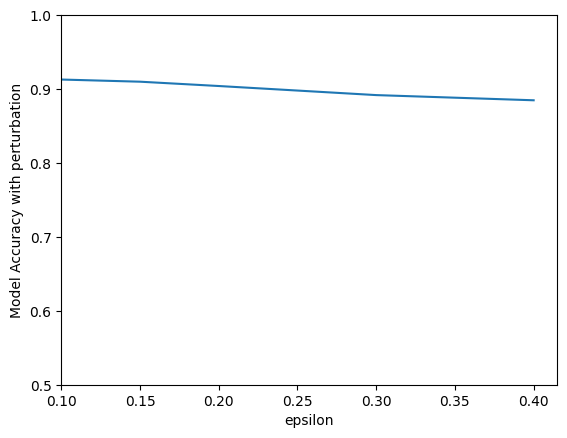

In [ ]:
y = [0.9128654970760234,0.9099415204678363, 0.904093567251462, 0.8918128654970761, 0.8847953216374269]
x = [0.1,0.15,0.2,0.3,0.4]
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.ylim(0.5,1)
plt.xlim(0.1)
plt.xlabel('epsilon')
plt.ylabel('Model Accuracy with perturbation')
plt.show()

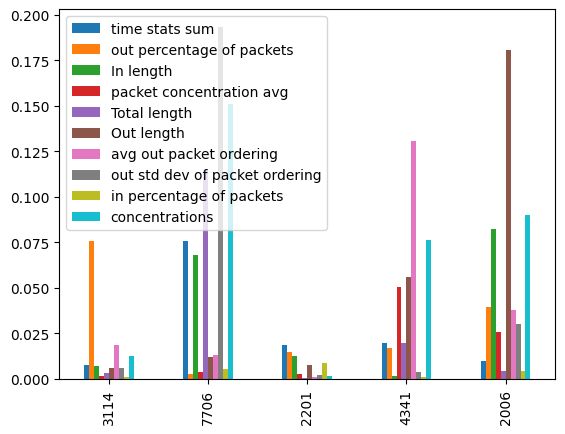

,time stats sum,out percentage of packets,In length,packet concentration avg,Total length,Out length,avg out packet ordering,out std dev of packet ordering,in percentage of packets,concentrations
3114,-0.007537,-0.075660,0.007092,-0.001400,-0.003398,-0.005832,0.018406,-0.006056,0.001327,-0.012908
7706,-0.076020,-0.002980,-0.068011,0.003597,-0.114765,0.012288,-0.013299,-0.193224,0.005302,0.150736
2201,-0.018635,-0.014589,-0.012681,-0.002847,0.000409,0.007498,-0.001289,0.002410,-0.008663,0.001885
4341,0.019726,0.016980,-0.001502,-0.050620,0.019577,-0.056265,-0.130426,0.003766,-0.001079,-0.076325
2006,0.009659,-0.039428,-0.082127,-0.025591,0.004351,-0.180823,0.038067,0.030250,0.004139,-0.089981


In [ ]:
diff_input_laplace = (perturbed_X_laplace.iloc[20:25,indices_reverse[0:10]] - X_valid.iloc[20:25,indices_reverse[0:10]])/X_valid.iloc[20:25,indices_reverse[0:10]]
diff_input_laplace.abs().plot(kind="bar")
import matplotlib.pyplot as plt
plt.show()
diff_input_laplace

In [ ]:
X_important = X_valid.iloc[:, indices_reverse]
X_important
t0 = np.max(X_important.iloc[:, 0])
t1 = np.max(X_important.iloc[:, 1])
plt.scatter(X_important.iloc[:, 0]/t0, X_important.iloc[:, 1]/t1, c=y_valid, cmap='viridis')

NameError: ignored

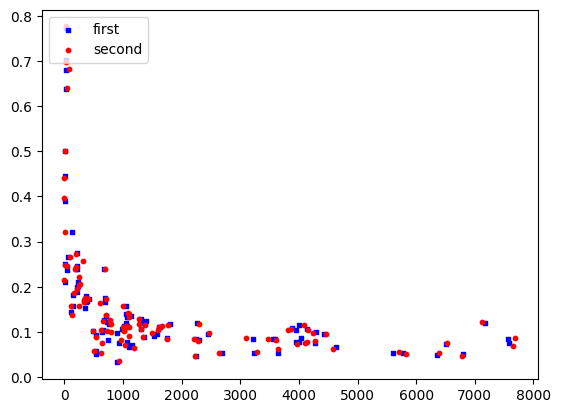

In [ ]:

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_important.iloc[0:100, 0], X_important.iloc[0:100, 1], s=10, c='b', marker="s", label='first')
ax1.scatter(perturbed_X_laplace.iloc[0:100, indices_reverse].iloc[0:100, 0],perturbed_X_laplace.iloc[0:100, indices_reverse].iloc[0:100, 1], s=10, c='r', marker="o", label='second')
plt.legend(loc='upper left')
plt.show()

In [ ]:
diff_input_laplace

,time stats sum,out percentage of packets,In length,packet concentration avg,Total length,Out length,avg out packet ordering,out std dev of packet ordering,in percentage of packets,concentrations
3114,-0.007537,-0.075660,0.007092,-0.001400,-0.003398,-0.005832,0.018406,-0.006056,0.001327,-0.012908
7706,-0.076020,-0.002980,-0.068011,0.003597,-0.114765,0.012288,-0.013299,-0.193224,0.005302,0.150736
2201,-0.018635,-0.014589,-0.012681,-0.002847,0.000409,0.007498,-0.001289,0.002410,-0.008663,0.001885
4341,0.019726,0.016980,-0.001502,-0.050620,0.019577,-0.056265,-0.130426,0.003766,-0.001079,-0.076325
2006,0.009659,-0.039428,-0.082127,-0.025591,0.004351,-0.180823,0.038067,0.030250,0.004139,-0.089981


<Figure size 640x480 with 0 Axes>

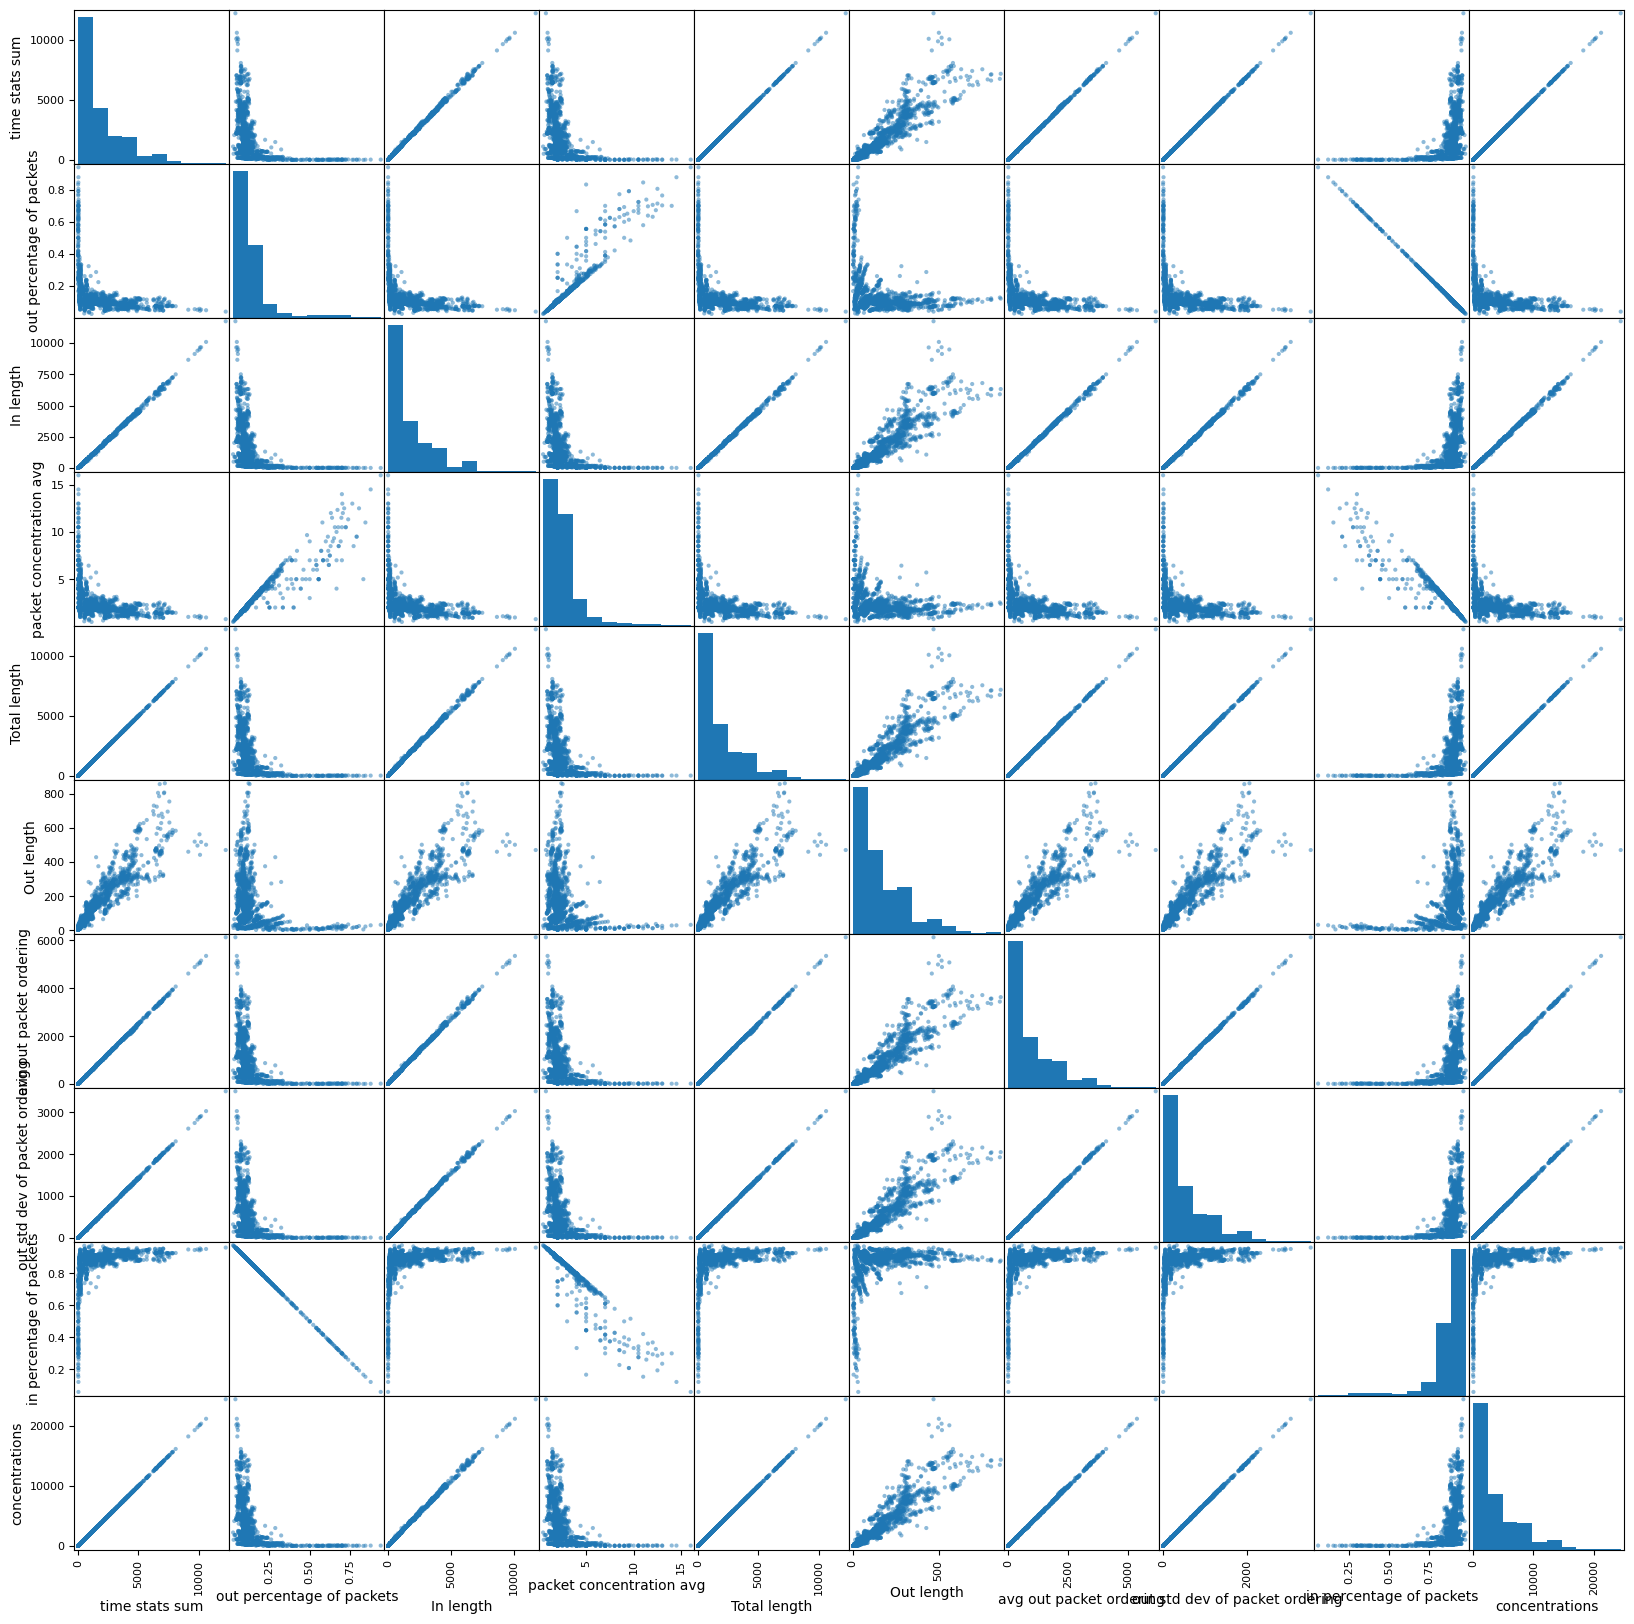

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
pd.plotting.scatter_matrix(X_valid.iloc[:,indices_reverse[0:10]],figsize=(20,20))
plt.figure()

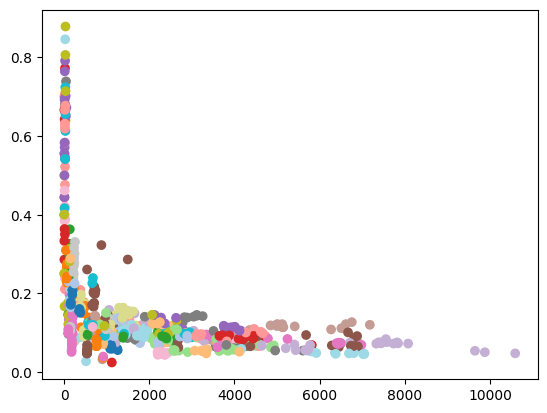

In [ ]:
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, 95)]
class_color_dict = {}
for i in range(95):
    class_color_dict[i] = colors[i]

colors_labels_original = [class_color_dict[c] for c in y_valid]
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.scatter(X_important.iloc[0:1000, 0], X_important.iloc[0:1000, 1], c=colors_labels_original[0:1000])
plt.show()

In [ ]:
class_0_indices = np.where(y_valid== 2)[0]
class_1_indices = np.where(y_valid== 1)[0]

In [ ]:
class_0_indices

array([  28,   34,  125,  150,  382,  397,  403,  431,  477,  519,  575,
        691,  724,  866,  902, 1020, 1143, 1171, 1198, 1547, 1618, 1630,
       1633])

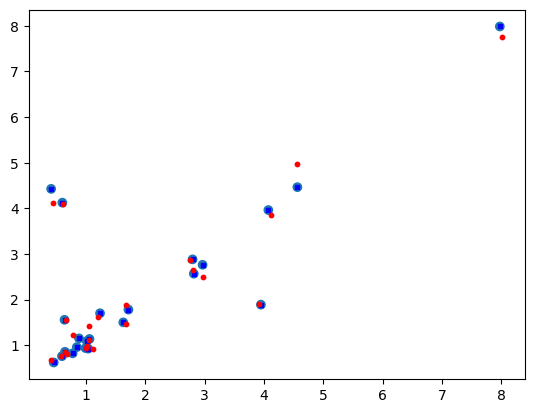

In [ ]:
class_0_indices
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, 95)]
class_color_dict = {}
for i in range(95):
    class_color_dict[i] = colors[i]

colors_labels_original = [class_color_dict[c] for c in y_valid.iloc[class_0_indices]]
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.scatter(X_valid.iloc[class_0_indices, 0], X_valid.iloc[class_0_indices, 1], c=colors_labels_original)
ax1.scatter(X_valid.iloc[class_0_indices, 0], X_valid.iloc[class_0_indices, 1], s=10, c='b', marker="s", label='first')
ax1.scatter(perturbed_X_laplace.iloc[class_0_indices, 0],perturbed_X_laplace.iloc[class_0_indices, 1], s=10, c='r', marker="o", label='second')
plt.show()

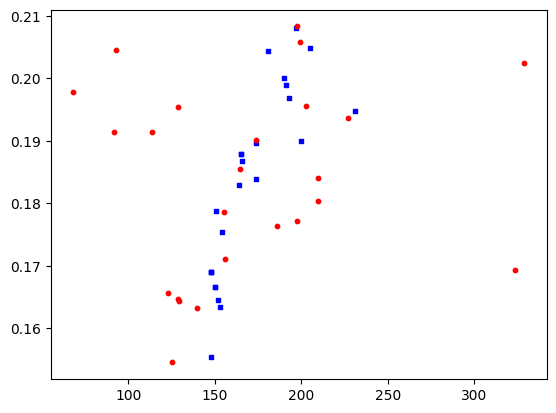

In [ ]:
class_1_indices
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, 95)]
class_color_dict = {}
for i in range(95):
    class_color_dict[i] = colors[i]

colors_labels_1_original = [class_color_dict[c] for c in y_valid.iloc[class_1_indices]]
fig = plt.figure()
ax1 = fig.add_subplot(111)
#plt.scatter(X_valid.iloc[class_1_indices, 0], X_valid.iloc[class_1_indices, 1], c=colors_labels_1_original)
ax1.scatter(X_valid.iloc[class_1_indices, indices_reverse[0]], X_valid.iloc[class_1_indices, indices_reverse[1]], s=10, c='b', marker="s", label='first')
ax1.scatter(perturbed_X_laplace.iloc[class_1_indices, indices_reverse[0]],perturbed_X_laplace.iloc[class_1_indices, indices_reverse[1]], s=10, c='r', marker="o", label='second')
plt.show()

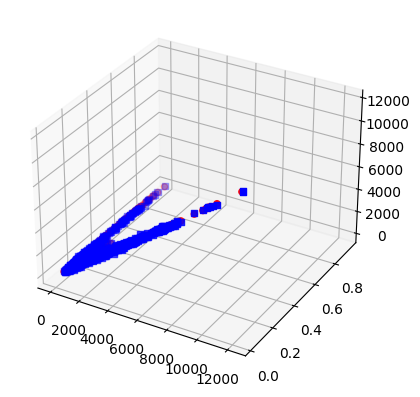

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_valid.iloc[:, indices_reverse[0]], X_valid.iloc[:, indices_reverse[1]], X_valid.iloc[:, indices_reverse[2]], c='r', marker='o')
ax.scatter(perturbed_X_laplace.iloc[:, indices_reverse[0]], perturbed_X_laplace.iloc[:, indices_reverse[1]], perturbed_X_laplace.iloc[:, indices_reverse[2]], c='b', marker="s")

In [ ]:
indices_reverse[0]

139

In [ ]:
y_valid.iloc[class_0_indices]

221    2
233    2
212    2
239    2
248    2
263    2
185    2
217    2
222    2
180    2
267    2
199    2
251    2
230    2
245    2
181    2
257    2
265    2
211    2
218    2
247    2
188    2
228    2
Name: 175, dtype: int64

In [ ]:
y_valid

1558    17
8167    90
5551    61
4626    51
623      6
        ..
624      6
2523    28
5213    57
2189    24
5807    64
Name: 175, Length: 1710, dtype: int64

In [ ]:
diff_input_laplace.iloc[indices[0:10]]

KeyError: ignored

In [ ]:
indices[0:10]

array([79, 93, 95, 99, 68, 94, 81, 83, 76, 82])

In [ ]:
X_valid

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
1558,0.434636,0.725160,0.417970,0.005869,0.044357,0.005324,0.027778,0.092387,0.023342,0.000000,...,0,0,2,0,1,1,3,3,20,9
8167,0.697325,5.374991,4.804465,0.002666,0.068044,0.003309,0.019989,0.314135,0.062415,0.000000,...,14,1,5,20,4,0,0,0,5,3
5551,1.203786,1.247889,0.668533,0.051210,0.309186,0.046256,0.150129,0.351878,0.101026,0.011424,...,0,0,0,0,0,0,0,0,0,0
4626,0.751468,0.837510,0.637308,0.036593,0.177147,0.030876,0.113410,0.251829,0.093703,0.011754,...,1,1,0,1,1,1,2,2,7,1
623,3.904627,3.847472,3.707737,0.024043,0.260516,0.022557,0.214875,0.709666,0.200959,0.000000,...,0,1,0,1,0,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,0.741804,0.874831,0.740640,0.013145,0.142736,0.012753,0.065879,0.230734,0.060791,0.000106,...,1,0,0,1,1,0,0,2,0,1
2523,0.848372,1.000475,0.687872,0.024297,0.172426,0.023010,0.091532,0.263556,0.075778,0.000048,...,1,1,6,2,5,4,11,10,16,5
5213,1.225491,0.749426,1.225491,0.005142,0.048198,0.004861,0.034108,0.088298,0.030686,0.000000,...,1,0,0,2,1,0,20,7,1,8
2189,0.981460,0.993184,0.879598,0.005961,0.104593,0.005840,0.044360,0.169938,0.037029,0.000000,...,1,0,0,0,2,0,0,2,0,0


0.7304093567251462

In [ ]:
perturbed_X_exp = perturb_data_exponential(X_valid, 0.5, importance)

In [ ]:
perturbed_X_exp

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
1558,0.431404,0.729949,0.413008,0.009537,0.026998,0.005533,0.038226,0.082126,0.020118,0.018632,...,0.000000,0.000000,2.003114,0.000000,0.990034,1.000673,2.989148,3.007172,19.989966,8.997088
8167,0.689910,5.372947,4.801582,0.000000,0.029824,0.000000,0.021118,0.314799,0.051629,0.012750,...,13.996016,1.001262,4.993765,20.011843,3.987111,0.000000,0.000000,0.030240,5.000604,2.987417
5551,1.209247,1.245662,0.674490,0.023689,0.329199,0.041042,0.153819,0.360553,0.094443,0.008629,...,0.003976,0.004393,0.003710,0.000000,0.000000,0.000950,0.017000,0.006947,0.004414,0.000000
4626,0.752640,0.836917,0.638611,0.040578,0.184385,0.033063,0.114443,0.257242,0.099887,0.020560,...,0.997147,0.996004,0.004327,0.998559,0.997859,1.001305,1.989155,2.029712,6.982751,0.997774
623,3.905368,3.842157,3.725691,0.012321,0.264208,0.021192,0.199184,0.708153,0.203684,0.000000,...,0.001730,1.002658,0.001804,0.986530,0.000000,0.997324,0.002485,2.002843,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,0.735143,0.858154,0.745254,0.000000,0.139790,0.026591,0.063624,0.228271,0.063383,0.000000,...,0.999366,0.000000,0.000725,0.994679,1.004193,0.000000,0.000000,1.995726,0.001508,0.997561
2523,0.828290,0.990384,0.689024,0.022209,0.161983,0.004353,0.092692,0.288179,0.081588,0.000959,...,0.999946,1.000276,5.989620,2.001911,5.002506,3.992128,11.003044,9.992967,16.007910,4.999478
5213,1.230296,0.751477,1.209032,0.000000,0.048151,0.000000,0.045266,0.079711,0.025731,0.000000,...,1.003950,0.000000,0.000000,1.994930,0.996485,0.031074,20.030612,7.006262,1.023486,8.000461
2189,0.937156,0.989252,0.872700,0.002742,0.103775,0.003398,0.029173,0.175091,0.034568,0.016986,...,0.998148,0.000000,0.000000,0.000000,1.997621,0.003160,0.000000,1.987272,0.000000,0.003422


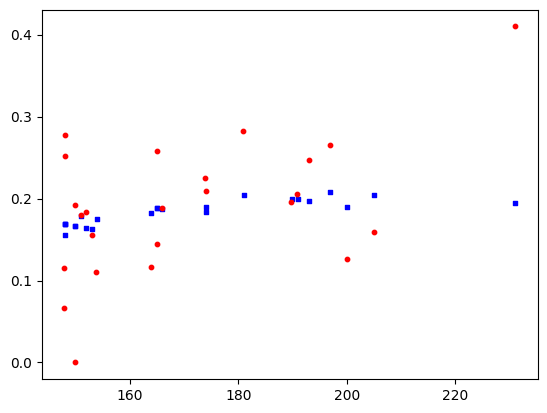

In [ ]:
class_1_indices
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, 95)]
class_color_dict = {}
for i in range(95):
    class_color_dict[i] = colors[i]

colors_labels_1_original = [class_color_dict[c] for c in y_valid.iloc[class_1_indices]]
fig = plt.figure()
ax1 = fig.add_subplot(111)
#plt.scatter(X_valid.iloc[class_1_indices, 0], X_valid.iloc[class_1_indices, 1], c=colors_labels_1_original)
ax1.scatter(X_valid.iloc[class_1_indices, indices_reverse[0]], X_valid.iloc[class_1_indices, indices_reverse[1]], s=10, c='b', marker="s", label='first')
ax1.scatter(perturbed_X_exp.iloc[class_1_indices, indices_reverse[0]],perturbed_X_exp.iloc[class_1_indices, indices_reverse[1]], s=10, c='r', marker="o", label='second')
plt.show()

In [ ]:
y_pred_perturbed_exp = model.predict(perturbed_X_exp)
metrics.accuracy_score(y_valid, y_pred_perturbed_exp)

0.9146198830409357

In [ ]:
def perturb_data_gaussian(data, epsilon, sensitivity):
    # Compute the scale parameter for the Gaussian noise
    scale = sensitivity / epsilon
    mean_value = np.mean(np.random.rand(*data.shape))
    # Generate Gaussian noise
    noise = np.random.normal(loc=0, scale=scale, size=data.shape)
    # Generate random signs for the noise
    signs = np.sign(np.random.rand(*data.shape) - mean_value)
    # Add the signed noise to the data
    perturbed_data = data + signs * noise
    return perturbed_data

In [ ]:
perturbed_X_gaussian = perturb_data_gaussian(X_valid, 0.1, importance)
perturbed_X_gaussian

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
1558,0.441082,0.750622,0.412092,-0.017491,0.064977,0.005324,0.026481,0.148460,0.012203,0.068485,...,0.016779,-0.015258,2.005102,0.016842,1.035422,1.032062,2.986822,2.956813,20.048899,9.003945
8167,0.717606,5.352340,4.810617,0.000810,0.031069,0.049941,-0.073804,0.326098,0.043376,0.028701,...,13.993118,0.991057,4.997551,19.963577,4.024372,0.040625,-0.020088,0.043815,4.992530,2.992938
5551,1.177451,1.170125,0.619426,0.098740,0.286642,0.023531,0.094413,0.358842,0.073830,0.071214,...,0.001142,-0.023673,0.006912,-0.020192,-0.041717,0.060694,-0.044549,0.032293,0.079072,0.000524
4626,0.713893,0.820377,0.628299,-0.048006,0.189816,0.117375,0.097856,0.272360,0.050702,-0.039789,...,0.985018,1.029278,-0.009235,0.977698,1.042594,1.053976,2.017097,1.975335,7.000852,0.980592
623,3.934175,3.818701,3.761613,-0.000578,0.388516,0.055414,0.295683,0.673989,0.262203,-0.063241,...,0.009644,1.013830,0.015266,0.992654,0.025746,0.994243,0.021792,1.977711,-0.007046,-0.010179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,0.760769,0.836317,0.701397,-0.017243,0.178953,0.008025,0.126078,0.311111,0.080568,-0.047922,...,0.996453,-0.004882,0.013134,1.028272,1.009170,0.012668,0.011479,1.977121,0.006332,0.976231
2523,0.793207,0.984192,0.652286,0.083559,0.153867,0.020076,0.141014,0.234060,0.068093,-0.002131,...,0.983484,1.019424,6.015199,2.007030,5.021862,3.975975,11.072833,9.907301,16.014248,5.006083
5213,1.230877,0.682799,1.168702,0.005229,0.096236,0.001827,0.048603,0.134181,0.068066,0.066688,...,1.008243,-0.002285,0.004704,2.025854,1.015568,0.012664,19.979541,6.996615,0.988536,7.999166
2189,0.979615,0.886561,0.915473,-0.146314,0.064256,0.003415,-0.054086,0.221031,0.043928,0.055803,...,1.003610,0.002302,0.002425,0.000794,1.948009,0.007120,-0.043417,2.014339,0.019714,0.051568


In [ ]:
y_pred_perturbed_gaussian = model.predict(perturbed_X_gaussian)
metrics.accuracy_score(y_valid, y_pred_perturbed_gaussian)

0.9105263157894737

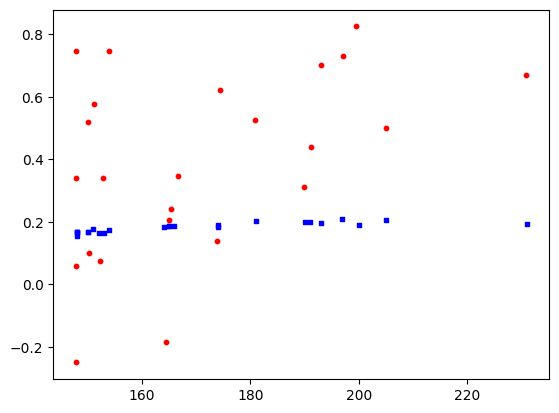

In [ ]:
class_1_indices
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, 95)]
class_color_dict = {}
for i in range(95):
    class_color_dict[i] = colors[i]

colors_labels_1_original = [class_color_dict[c] for c in y_valid.iloc[class_1_indices]]
fig = plt.figure()
ax1 = fig.add_subplot(111)
#plt.scatter(X_valid.iloc[class_1_indices, 0], X_valid.iloc[class_1_indices, 1], c=colors_labels_1_original)
ax1.scatter(X_valid.iloc[class_1_indices, indices_reverse[0]], X_valid.iloc[class_1_indices, indices_reverse[1]], s=10, c='b', marker="s", label='first')
ax1.scatter(perturbed_X_gaussian.iloc[class_1_indices, indices_reverse[0]],perturbed_X_gaussian.iloc[class_1_indices, indices_reverse[1]], s=10, c='r', marker="o", label='second')
plt.show()

In [ ]:
# Generate adversarial examples using FGSM with feature importance
def fgsm_attack_with_importance(model, x, y, epsilon, n_features):
    # Compute the feature importances
    importances = model.feature_importances_
    # Sort the features by importance
    indices = np.argsort(importances)[::-1][:n_features]
    # Create a copy of the input data point
    x_adv = np.copy(x)
    grad = model.predict_proba(x_adv.reshape(1, -1))[0]
    grad[y] -= 1
    gradient_sum = 0
    # Compute the gradient of the model's decision function with respect to the input data
    for estimator in model.estimators_:
        gradient = estimator.decision_path(x_adv.reshape(1, -1)).todense()
        #pdb.set_trace()
        gradient = gradient[:, indices].T
        gradient_sum += gradient
    gradient_avg = gradient_sum / len(model.estimators_)
    grad = grad.reshape(-1, 1)
    # Compute the sign of the gradient
    sign = np.sign(gradient)
    # Generate the perturbation using the sign of the gradient and the epsilon parameter
    perturbation = epsilon * sign
    # Add the perturbation to the selected features to generate the adversarial example
    x_adv[:,indices] += perturbation.T
    return x_adv

In [ ]:
epsilon = 0.4
n_features = 5
x_adv_points = []
for i in range(X_valid.shape[0]):
    x_adv = fgsm_attack_with_importance(model, X_valid.iloc[[i]], y_valid.iloc[[i]], epsilon, n_features)
    x_adv_points.append(x_adv)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does 

In [ ]:
y_valid.iloc[[0]]

1558    17
Name: 175, dtype: int64

In [ ]:
len(x_adv_points)
my_array = np.concatenate(x_adv_points, axis=0)
perturbed_X_fsgm = pd.DataFrame(my_array)

In [ ]:
perturbed_X_fsgm

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,0.434636,0.725160,0.417970,0.005869,0.044357,0.005324,0.027778,0.092387,0.023342,0.000000,...,0.0,0.0,2.0,0.0,1.0,1.0,3.0,3.0,20.0,9.0
1,0.697325,5.374991,4.804465,0.002666,0.068044,0.003309,0.019989,0.314135,0.062415,0.000000,...,14.0,1.0,5.0,20.0,4.0,0.0,0.0,0.0,5.0,3.0
2,1.203786,1.247889,0.668533,0.051210,0.309186,0.046256,0.150129,0.351878,0.101026,0.011424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.751468,0.837510,0.637308,0.036593,0.177147,0.030876,0.113410,0.251829,0.093703,0.011754,...,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,7.0,1.0
4,3.904627,3.847472,3.707737,0.024043,0.260516,0.022557,0.214875,0.709666,0.200959,0.000000,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705,0.741804,0.874831,0.740640,0.013145,0.142736,0.012753,0.065879,0.230734,0.060791,0.000106,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0
1706,0.848372,1.000475,0.687872,0.024297,0.172426,0.023010,0.091532,0.263556,0.075778,0.000048,...,1.0,1.0,6.0,2.0,5.0,4.0,11.0,10.0,16.0,5.0
1707,1.225491,0.749426,1.225491,0.005142,0.048198,0.004861,0.034108,0.088298,0.030686,0.000000,...,1.0,0.0,0.0,2.0,1.0,0.0,20.0,7.0,1.0,8.0
1708,0.981460,0.993184,0.879598,0.005961,0.104593,0.005840,0.044360,0.169938,0.037029,0.000000,...,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0


In [ ]:
y_pred_perturbed_fsgm = model.predict(perturbed_X_fsgm)
metrics.accuracy_score(y_valid, y_pred_perturbed_fsgm)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.9192982456140351

In [ ]:
from sklearn.ensemble import RandomForestClassifier

class SmoothedRandomForestClassifier(RandomForestClassifier):
    def __init__(self, n_estimators=100, criterion='gini', max_depth=None, 
                 min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                 max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                 bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                 verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, smooth_alpha=0.5):
        super().__init__(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                         min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                         min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, 
                         max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, 
                         bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
                         verbose=verbose, warm_start=warm_start, class_weight=class_weight, ccp_alpha=ccp_alpha)
        self.smooth_alpha = smooth_alpha
    
    def fit(self, X, y, sample_weight=None):
        super().fit(X, y, sample_weight=sample_weight)
        
        # Get the predicted probabilities for the training data
        y_prob = self.predict_proba(X)

        # Calculate the average predicted probabilities for each class
        avg_prob = y_prob.mean(axis=0)

        # Calculate the difference between the average predicted probability and the predicted probability for each observation
        diff_train = avg_prob - y_prob

        # Calculate the smoothed predicted probabilities for the training data
        y_prob_smoothed = y_prob + self.smooth_alpha * diff_train

        # Set the smoothed predicted probabilities as the new training data for the forest
        self.X_train_ = X
        self.y_train_ = y_prob_smoothed.argmax(axis=1)

        # Set the number of features used in each tree to the square root of the total number of features
        self.max_features_ = int(np.sqrt(X.shape[1]))
        
        # Build a new forest using the smoothed predicted probabilities as the training data
        self.estimators_ = []
        for i in range(self.n_estimators):
            tree = self._make_estimator(append=False, random_state=self.random_state)
            tree.fit(self.X_train_, self.y_train_)
            self.estimators_.append(tree)
            
        return self

In [ ]:
rf_smooth = SmoothedRandomForestClassifier(smooth_alpha=0.5, random_state=42)

In [ ]:
rf_smooth.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


SmoothedRandomForestClassifier(random_state=42)

In [ ]:
y_pred_smooth = rf_smooth.predict(X_valid)
metrics.accuracy_score(y_valid, y_pred_smooth)

0.7549707602339182

TypeError: ignored

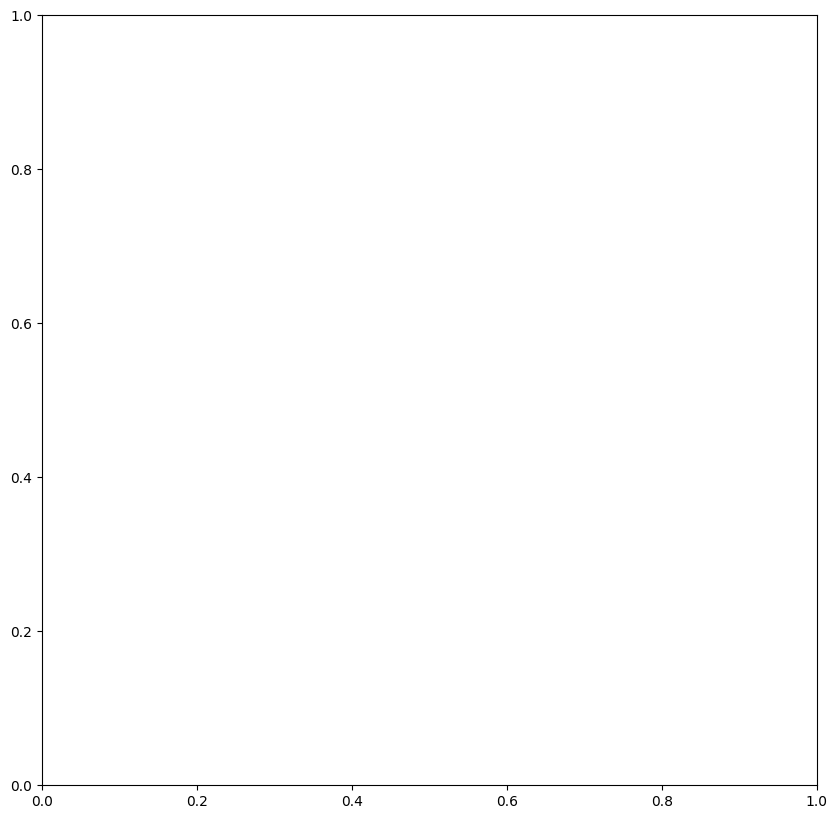

In [ ]:
# from sklearn.inspection import PartialDependenceDisplay
# import matplotlib.pyplot as plt
# from sklearn.inspection import partial_dependence
# fig, ax = plt.subplots()
# pdp, axes = partial_dependence(model, X_valid, features=[0, 1], grid_resolution=50)
# display = PartialDependenceDisplay(pdp, features=[0, 1])
# display.plot(ax=ax)
# plt.show()

In [ ]:
k = 5
top_features = indices[:k]

In [ ]:
features = [0, 1, (0, 1)]
PartialDependenceDisplay.from_estimator(model, X_train, features,target=0)

In [ ]:
pdp

'average'

In [ ]:
import foolbox

In [ ]:
# fmodel = foolbox.models.CallableModelWrapper(rf.predict_proba, bounds=(-5, 5), num_classes=95)
# fmodel = foolbox.models.ModelWrapper(lambda x: rf.predict_proba(x.reshape((1,) + x.shape)), bounds=(-5, 5), num_classes=95)
# fmodel = foolbox.models.PyTorchModel(model, bounds=(-5, 5))
# epsilons = [0.0, 0.1, 0.5, 1.0]
# adv_images = []
# for eps in epsilons:
#     adv_images.append(foolbox.attacks.FGSM(fmodel).run(X_valid, y_valid, epsilon=eps))


ValueError: ignored

In [185]:
from scipy.special import add_newdocs
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

# def decision_tree_boundary_attack(X, y, rf_model, selected_features, k=2, epsilon=0.1):
#     x_adv = np.copy(X)
#     n_features = len(selected_features)
#     for i in range(len(X.shape[0])):
#         x = X.iloc[i,selected_features]
#         y_true = y.iloc[i]
#         df = pd.DataFrame([(X_valid.iloc[i,:])])
#         y_pred = rf_model.predict(df)[0]
#         while y_pred == y_true:
#             grad = np.zeros(n_features)
#             for tree in rf_model.estimators_:
#                 tree_grad = tree.tree_.compute_feature_importances(normalize=False)[selected_features]
#                 grad += tree_grad
#             idx = np.argsort(-np.abs(grad))[:k]
#             threshold = []
#             for tree in rf_model.estimators_:
#                 node_id = tree.apply(df)[0]
#                 tree_threshold = tree.tree_.threshold[node_id]
#                 threshold.append(tree_threshold)
#             pdb.set_trace()
#             print(threshold)
#             threshold = np.mean(threshold)
#             print(threshold)
#             direction = np.sign(grad[idx])
#             x[idx] += epsilon * direction
#             x[x < threshold] = threshold
#             x[x > threshold] = x[x > threshold] - epsilon * direction
#             y_pred = rf_model.predict(df)[0]
#         x_adv[i][selected_features] = x
#     return x_adv

def decision_tree_boundary_attack(X, y, rf_model, selected_features=None, epsilon=0.1):
    if selected_features is None:
        # Use the most important feature for each data point
        selected_features = np.argmax(rf_model.predict_proba(X), axis=1)
    x_adv = np.copy(X)
    n_features = X.shape[1]
    for i in range(len(X)):
        x = X.iloc[i]
        y_true = y.iloc[i]
        df = pd.DataFrame([(X_valid.iloc[i,:])])
        y_pred = rf_model.predict(df)[0]
        count=0
        print(str(i)+"test datapoint")
        while y_pred == y_true and count<5:
            grad = np.zeros(n_features)
            for tree in rf_model.estimators_:
                tree_grad = tree.tree_.compute_feature_importances(normalize=False)
                grad += tree_grad
            direction = np.sign(grad)
            #pdb.set_trace()
            idx = np.argsort(-np.abs(grad))[:len(selected_features)]
            threshold = np.mean([tree.tree_.threshold[tree.apply(df)[0]] for tree in rf_model.estimators_])
            #x[selected_features] += epsilon * direction[selected_features]
            x[x < threshold] = threshold
            for j in idx:
                if j in selected_features:
                    x[j] += epsilon * direction[j]*rf_model.feature_importances_[j]
                    x[x < threshold] = threshold
            y_pred = rf_model.predict(df)[0]
            count=count+1
        x_adv[i] = x
    return x_adv

# # Function to generate adversarial examples using decision tree boundary attack
# def decision_tree_boundary_attack(X, y, rf_model, selected_features, epsilon=0.1):
#     x_adv = np.copy(X)
#     n_features = len(selected_features)
#     for i in range(len(X)):
#         x = X.iloc[i,selected_features]
#         y_true = y.iloc[i]
#         df = pd.DataFrame([(X_valid.iloc[i,:])])
#         #df
#         y_pred = rf_model.predict(df)[0]
#         while y_pred == y_true and i<1:
#             grad = rf_model.estimators_[0].tree_.compute_feature_importances(normalize=False)[selected_features]
#             print(grad)
#             idx = np.random.choice(np.where(np.abs(grad)>0)[0])
#             df = pd.DataFrame([(X_valid.iloc[i,:])])
#             #df
#             node_id = rf_model.estimators_[0].apply(df)[0]
#             threshold = rf_model.estimators_[0].tree_.threshold[node_id]
#             print(threshold)
#             direction = np.sign(grad[idx])
#             x[idx] += epsilon * direction
#             x[x < threshold] = threshold
#             x[x > threshold] = x[x > threshold] - epsilon * direction
#             df = pd.DataFrame([(X_valid.iloc[i,:])])
#             df
#             y_pred = rf_model.predict(df)[0]
#             print(y_pred)
#         x_adv[i][selected_features] = x
#     return x_adv

# def decision_tree_boundary_attack(X, y, rf_model, selected_features, k=2, epsilon=0.1):
#     x_adv = np.copy(X)
#     n_features = len(selected_features)
#     for i in range(len(X)):
#         x = X.iloc[i,selected_features]
#         y_true = y.iloc[i]
#         df = pd.DataFrame([(X_valid.iloc[i,:])])
#         df
#         y_pred = rf_model.predict(df)[0]
#         while y_pred == y_true:
#             grad = np.zeros(n_features)
#             for tree in rf_model.estimators_:
#                 tree_grad = tree.tree_.compute_feature_importances(normalize=False)[selected_features]
#                 grad += tree_grad
#             idx = np.argsort(-np.abs(grad))[:k]
#             node_id = rf_model.estimators_[0].apply(df)[0]
#             threshold = rf_model.estimators_[0].tree_.threshold[node_id]
#             print(threshold)
#             direction = np.sign(grad[idx])
#             print(direction)
#             x[idx] += epsilon * direction
#             x[x < threshold] = threshold
#             x[x > threshold] = x[x > threshold] - epsilon * direction
#             y_pred = rf_model.predict(df)[0]
#         x_adv[i][selected_features] = x
#     return x_adv


In [ ]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [199]:
indices_reverse  = np.flipud(indices)
x_adv_dtba = decision_tree_boundary_attack(X_valid[0:100],y_valid[0:100], model, indices_reverse[0:5],0.2)

In [188]:
len(x_adv_dtba[0])
df = pd.DataFrame(x_adv_dtba, columns=col_list)

In [189]:
df

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
0,0.434636,0.725160,0.417970,0.005869,0.044357,0.005324,0.027778,0.092387,0.023342,0.000000,...,0.0,0.0,2.0,0.0,1.0,1.0,3.0,3.0,20.0,9.0
1,0.697325,5.374991,4.804465,0.002666,0.068044,0.003309,0.019989,0.314135,0.062415,0.000000,...,14.0,1.0,5.0,20.0,4.0,0.0,0.0,0.0,5.0,3.0
2,1.203786,1.247889,0.668533,0.051210,0.309186,0.046256,0.150129,0.351878,0.101026,0.011424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.751468,0.837510,0.637308,0.036593,0.177147,0.030876,0.113410,0.251829,0.093703,0.011754,...,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,7.0,1.0
4,3.904627,3.847472,3.707737,0.024043,0.260516,0.022557,0.214875,0.709666,0.200959,0.000000,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.560377,1.087461,0.778507,0.004241,0.051417,0.004065,0.023565,0.096974,0.023324,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
96,2.992235,2.110683,1.561590,0.010282,0.107699,0.010131,0.093530,0.248548,0.072393,0.000000,...,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0
97,1.373161,1.873780,1.079797,0.006721,0.068889,0.006170,0.049355,0.217273,0.042506,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0
98,1.258356,1.243348,1.173568,0.007116,0.068754,0.007025,0.046284,0.151802,0.045441,0.000000,...,0.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,1.0


In [190]:
y_pred_adv = model.predict(df)

In [191]:
metrics.accuracy_score(y_valid[0:100], y_pred_adv)

0.9

In [163]:
y_pred_adv

array([17, 90, 61, 51, 11, 14, 66, 30, 12, 81, 35, 66,  5, 76, 12, 94, 76,
       13, 46, 30, 34, 85, 24, 48, 22, 87, 89, 65,  2, 71, 34, 49, 44, 82,
        2, 69, 64, 69, 76, 52, 93, 48,  6, 12, 30, 46, 45, 40, 51, 63, 37,
       87, 18, 35, 14, 54, 49, 38, 71, 16, 67, 37, 38, 27, 35, 48, 83, 84,
       15,  8, 30, 71, 72,  8, 40, 12, 64, 48, 25, 88, 91,  0, 30, 45, 44,
       84, 62, 12, 91, 27, 87, 53, 63, 33, 19, 60, 26, 20, 77, 40])

In [ ]:
X_valid[0:10]

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
1558,0.434636,0.725160,0.417970,0.005869,0.044357,0.005324,0.027778,0.092387,0.023342,0.000000,...,0,0,2,0,1,1,3,3,20,9
8167,0.697325,5.374991,4.804465,0.002666,0.068044,0.003309,0.019989,0.314135,0.062415,0.000000,...,14,1,5,20,4,0,0,0,5,3
5551,1.203786,1.247889,0.668533,0.051210,0.309186,0.046256,0.150129,0.351878,0.101026,0.011424,...,0,0,0,0,0,0,0,0,0,0
4626,0.751468,0.837510,0.637308,0.036593,0.177147,0.030876,0.113410,0.251829,0.093703,0.011754,...,1,1,0,1,1,1,2,2,7,1
623,3.904627,3.847472,3.707737,0.024043,0.260516,0.022557,0.214875,0.709666,0.200959,0.000000,...,0,1,0,1,0,1,0,2,0,0
1298,0.601766,0.798185,0.523688,0.105493,0.325022,0.087611,0.172464,0.307917,0.148866,0.101061,...,0,0,0,0,0,0,0,0,0,0
5991,1.983667,3.290156,1.575045,0.005943,0.110808,0.005990,0.055056,0.307275,0.051847,0.000000,...,1,0,0,1,1,0,0,1,1,0
2718,1.896322,2.889445,2.889445,0.998140,0.622320,0.474148,0.672312,0.954104,0.733014,1.261476,...,0,0,0,0,0,0,0,0,0,0
1111,0.745402,3.888661,3.507886,0.060556,0.313616,0.064608,0.145968,0.570660,0.250303,0.011239,...,13,11,0,0,0,1,0,0,0,0
7320,0.931921,1.377209,0.964538,0.025120,0.250049,0.024850,0.086294,0.352552,0.089822,0.002718,...,1,2,1,3,12,16,62,24,135,24


In [ ]:
X_valid.loc[[623]]

,In packet Time,Out packet Time,Total packet time,avg in packet time,avg out packet time,avg total time,In std deviation time,Out std deviation time,total std deviation time,In 75% quantile time,...,chunk_per_sec_2,chunk_per_sec_3,chunk_per_sec_4,chunk_per_sec_5,chunk_per_sec_6,chunk_per_sec_7,chunk_per_sec_8,chunk_per_sec_9,chunk_per_sec_10,chunk_per_sec_11
623,3.904627,3.847472,3.707737,0.024043,0.260516,0.022557,0.214875,0.709666,0.200959,0.0,...,0,1,0,1,0,1,0,2,0,0


In [173]:
df.iloc[10,indices_reverse[0:10]]

In length                        306.000000
in percentage of packets           0.820375
Out length                        67.000000
in std dev of packet ordering    122.328447
out percentage of packets          0.179625
concentrations                   746.000000
time stats sum                   373.000000
avg out packet ordering          181.238562
Total length                     373.000000
intertime stats sum               67.000000
Name: 10, dtype: float64

In [174]:
X_valid.iloc[10,indices_reverse[0:10]]

In length                        306.000000
in percentage of packets           0.820375
Out length                        67.000000
in std dev of packet ordering    122.328447
out percentage of packets          0.179625
concentrations                   746.000000
time stats sum                   373.000000
avg out packet ordering          181.238562
Total length                     373.000000
intertime stats sum               67.000000
Name: 6086, dtype: float64

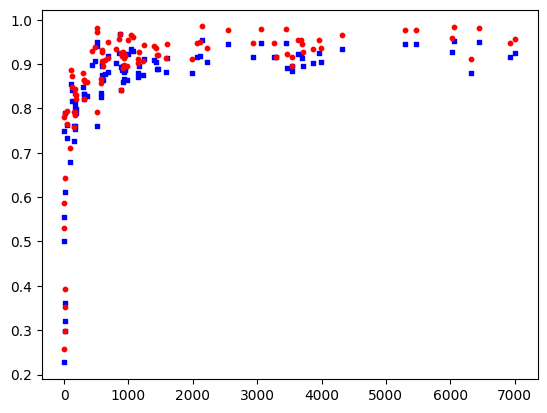

In [198]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#plt.scatter(X_valid.iloc[class_1_indices, 0], X_valid.iloc[class_1_indices, 1], c=colors_labels_1_original)
random_numbers = [random.randint(-1, 1) for i in range(100)]
ax1.scatter(X_valid.iloc[0:100, indices_reverse[0]], X_valid.iloc[0:100, indices_reverse[1]], s=10, c='b', marker="s", label='first')
ax1.scatter(df.iloc[:, indices_reverse[0]],df.iloc[:, indices_reverse[1]], s=10, c='r', marker="o", label='second')
plt.show()

In [196]:
np.max(X_valid.iloc[:,indices_reverse[0]])
#col_list[indices_reverse[0]]

11748

In [ ]:
y_valid[0:10]

1558    17
8167    90
5551    61
4626    51
623      6
1298    14
5991    66
2718    30
1111    12
7320    81
Name: 175, dtype: int64

In [ ]:
X_valid[[1558]]

5

In [ ]:
# estimator_weights = model.n_samples_per_estimator_ / float(sum(model.n_samples_per_estimator_))

# # Print the weights of each estimator
# for i, weight in enumerate(estimator_weights):
#     print(f"Estimator {i}: {weight:.4f}")

AttributeError: ignored

In [ ]:
pd.DataFrame((X_valid.iloc[0,indices_reverse]))
df = pd.DataFrame([(X_valid.iloc[0,indices_reverse])])
df.iloc[0,:]

time stats sum               2267.000000
out percentage of packets       0.120423
In length                    1994.000000
packet concentration avg        2.394737
Total length                 2267.000000
                                ...     
chunk_alt_conc_23               0.000000
chunk_alt_conc_54               0.000000
chunk_alt_conc_50               0.000000
chunk_alt_conc_48               0.000000
chunk_alt_conc_34               7.000000
Name: 1558, Length: 175, dtype: float64

In [ ]:
(X_valid.loc[indices[0]])

In packet Time          0.753365
Out packet Time         0.805664
Total packet time       0.569322
avg in packet time      0.045393
avg out packet time     0.253997
                         ...    
chunk_per_sec_7        77.000000
chunk_per_sec_8        46.000000
chunk_per_sec_9        68.000000
chunk_per_sec_10       10.000000
chunk_per_sec_11       14.000000
Name: 79, Length: 175, dtype: float64

In [ ]:
print(X_valid.index)

Int64Index([1558, 8167, 5551, 4626,  623, 1298, 5991, 2718, 1111, 7320,
            ...
            8451, 6251,  847, 1870, 7005,  624, 2523, 5213, 2189, 5807],
           dtype='int64', length=1710)


In [ ]:
df = pd.DataFrame([(X_valid.iloc[0,indices_reverse])])
df

,time stats sum,out percentage of packets,In length,packet concentration avg,Total length,Out length,avg out packet ordering,out std dev of packet ordering,in percentage of packets,concentrations,...,chunk_alt_conc_37,chunk_alt_conc_31,chunk_alt_conc_38,chunk_alt_conc_36,chunk_alt_conc_49,chunk_alt_conc_23,chunk_alt_conc_54,chunk_alt_conc_50,chunk_alt_conc_48,chunk_alt_conc_34
1558,2267.0,0.120423,1994.0,2.394737,2267.0,273.0,1133.814945,653.370954,0.879577,4534.0,...,2.0,7.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,7.0


In [ ]:
X_valid.columns[indices_reverse]

Index(['time stats sum', 'out percentage of packets', 'In length',
       'packet concentration avg', 'Total length', 'Out length',
       'avg out packet ordering', 'out std dev of packet ordering',
       'in percentage of packets', 'concentrations',
       ...
       'chunk_alt_conc_37', 'chunk_alt_conc_31', 'chunk_alt_conc_38',
       'chunk_alt_conc_36', 'chunk_alt_conc_49', 'chunk_alt_conc_23',
       'chunk_alt_conc_54', 'chunk_alt_conc_50', 'chunk_alt_conc_48',
       'chunk_alt_conc_34'],
      dtype='object', length=175)